/var/folders/lh/x3hrpfns0kvft_vn9ntrvglm0000gn/T/ipykernel_11303/2027423318.py:6: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_input = pd.read_csv('../Result_70.tsv',sep='\t')
/var/folders/lh/x3hrpfns0kvft_vn9ntrvglm0000gn/T/ipykernel_11303/2027423318.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_los['id'] = df_los['AppId']
/var/folders/lh/x3hrpfns0kvft_vn9ntrvglm0000gn/T/ipykernel_11303/2027423318.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_los.drop('AppId',axis=1,inplace=Tru

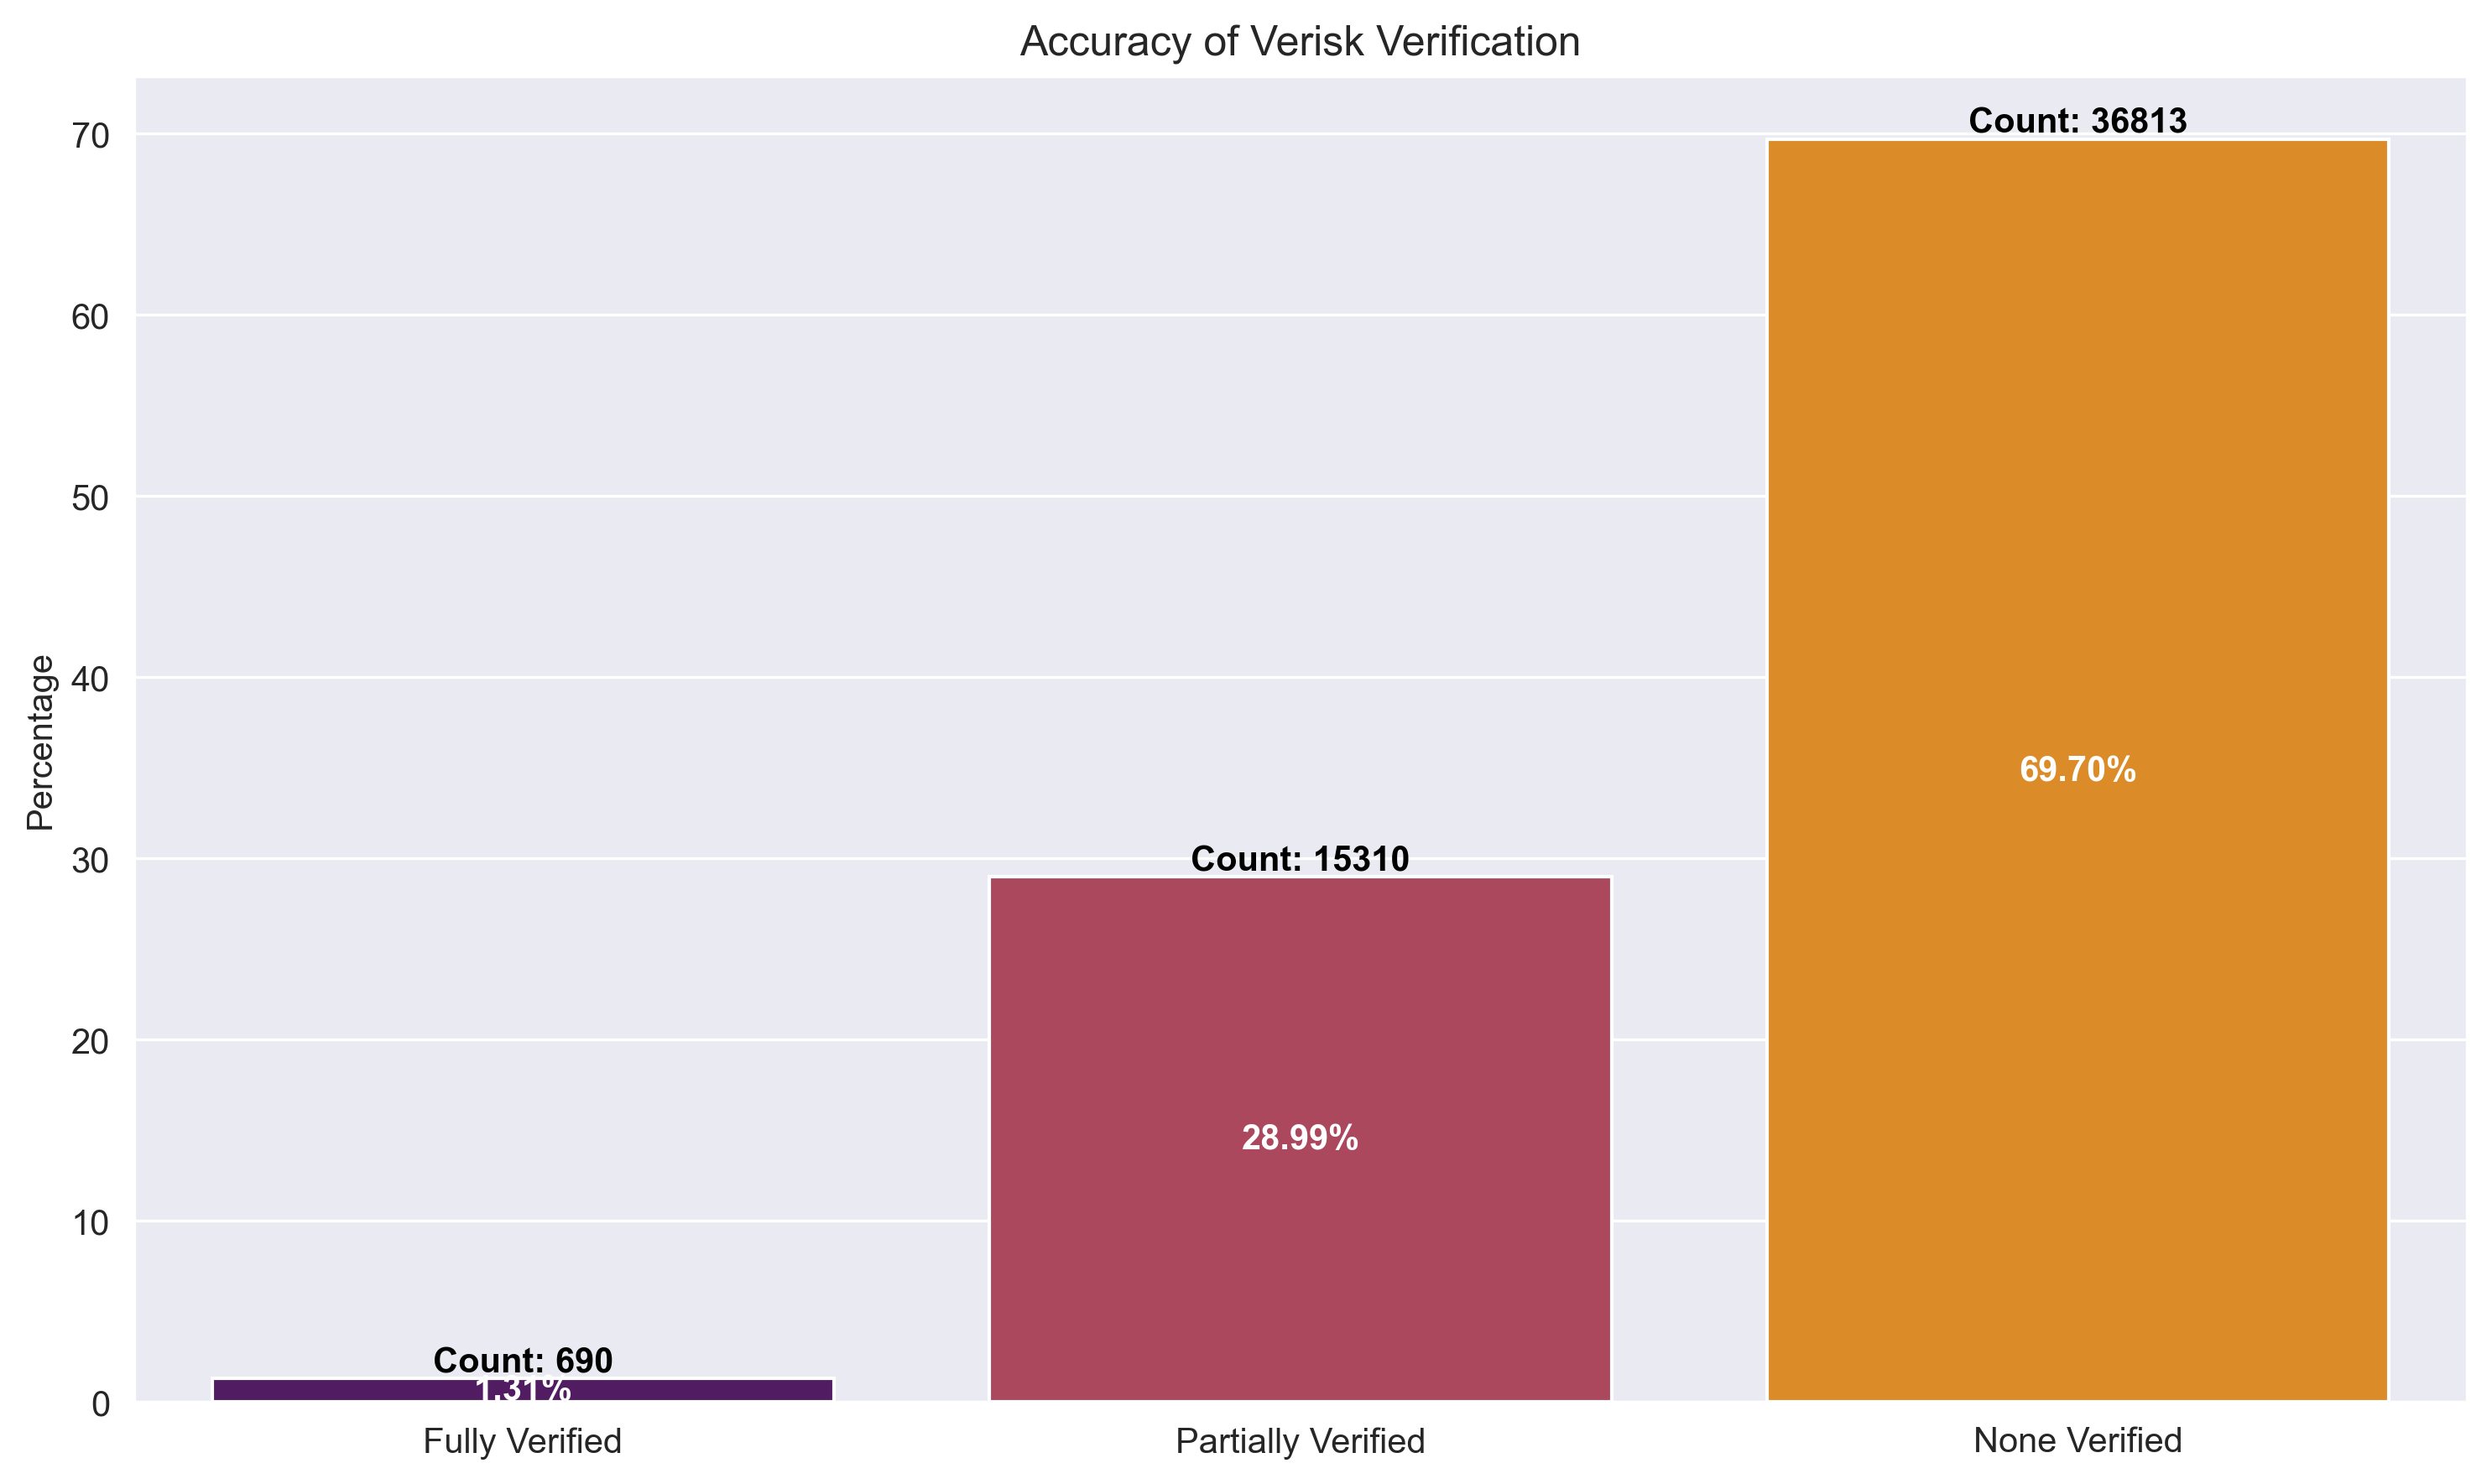

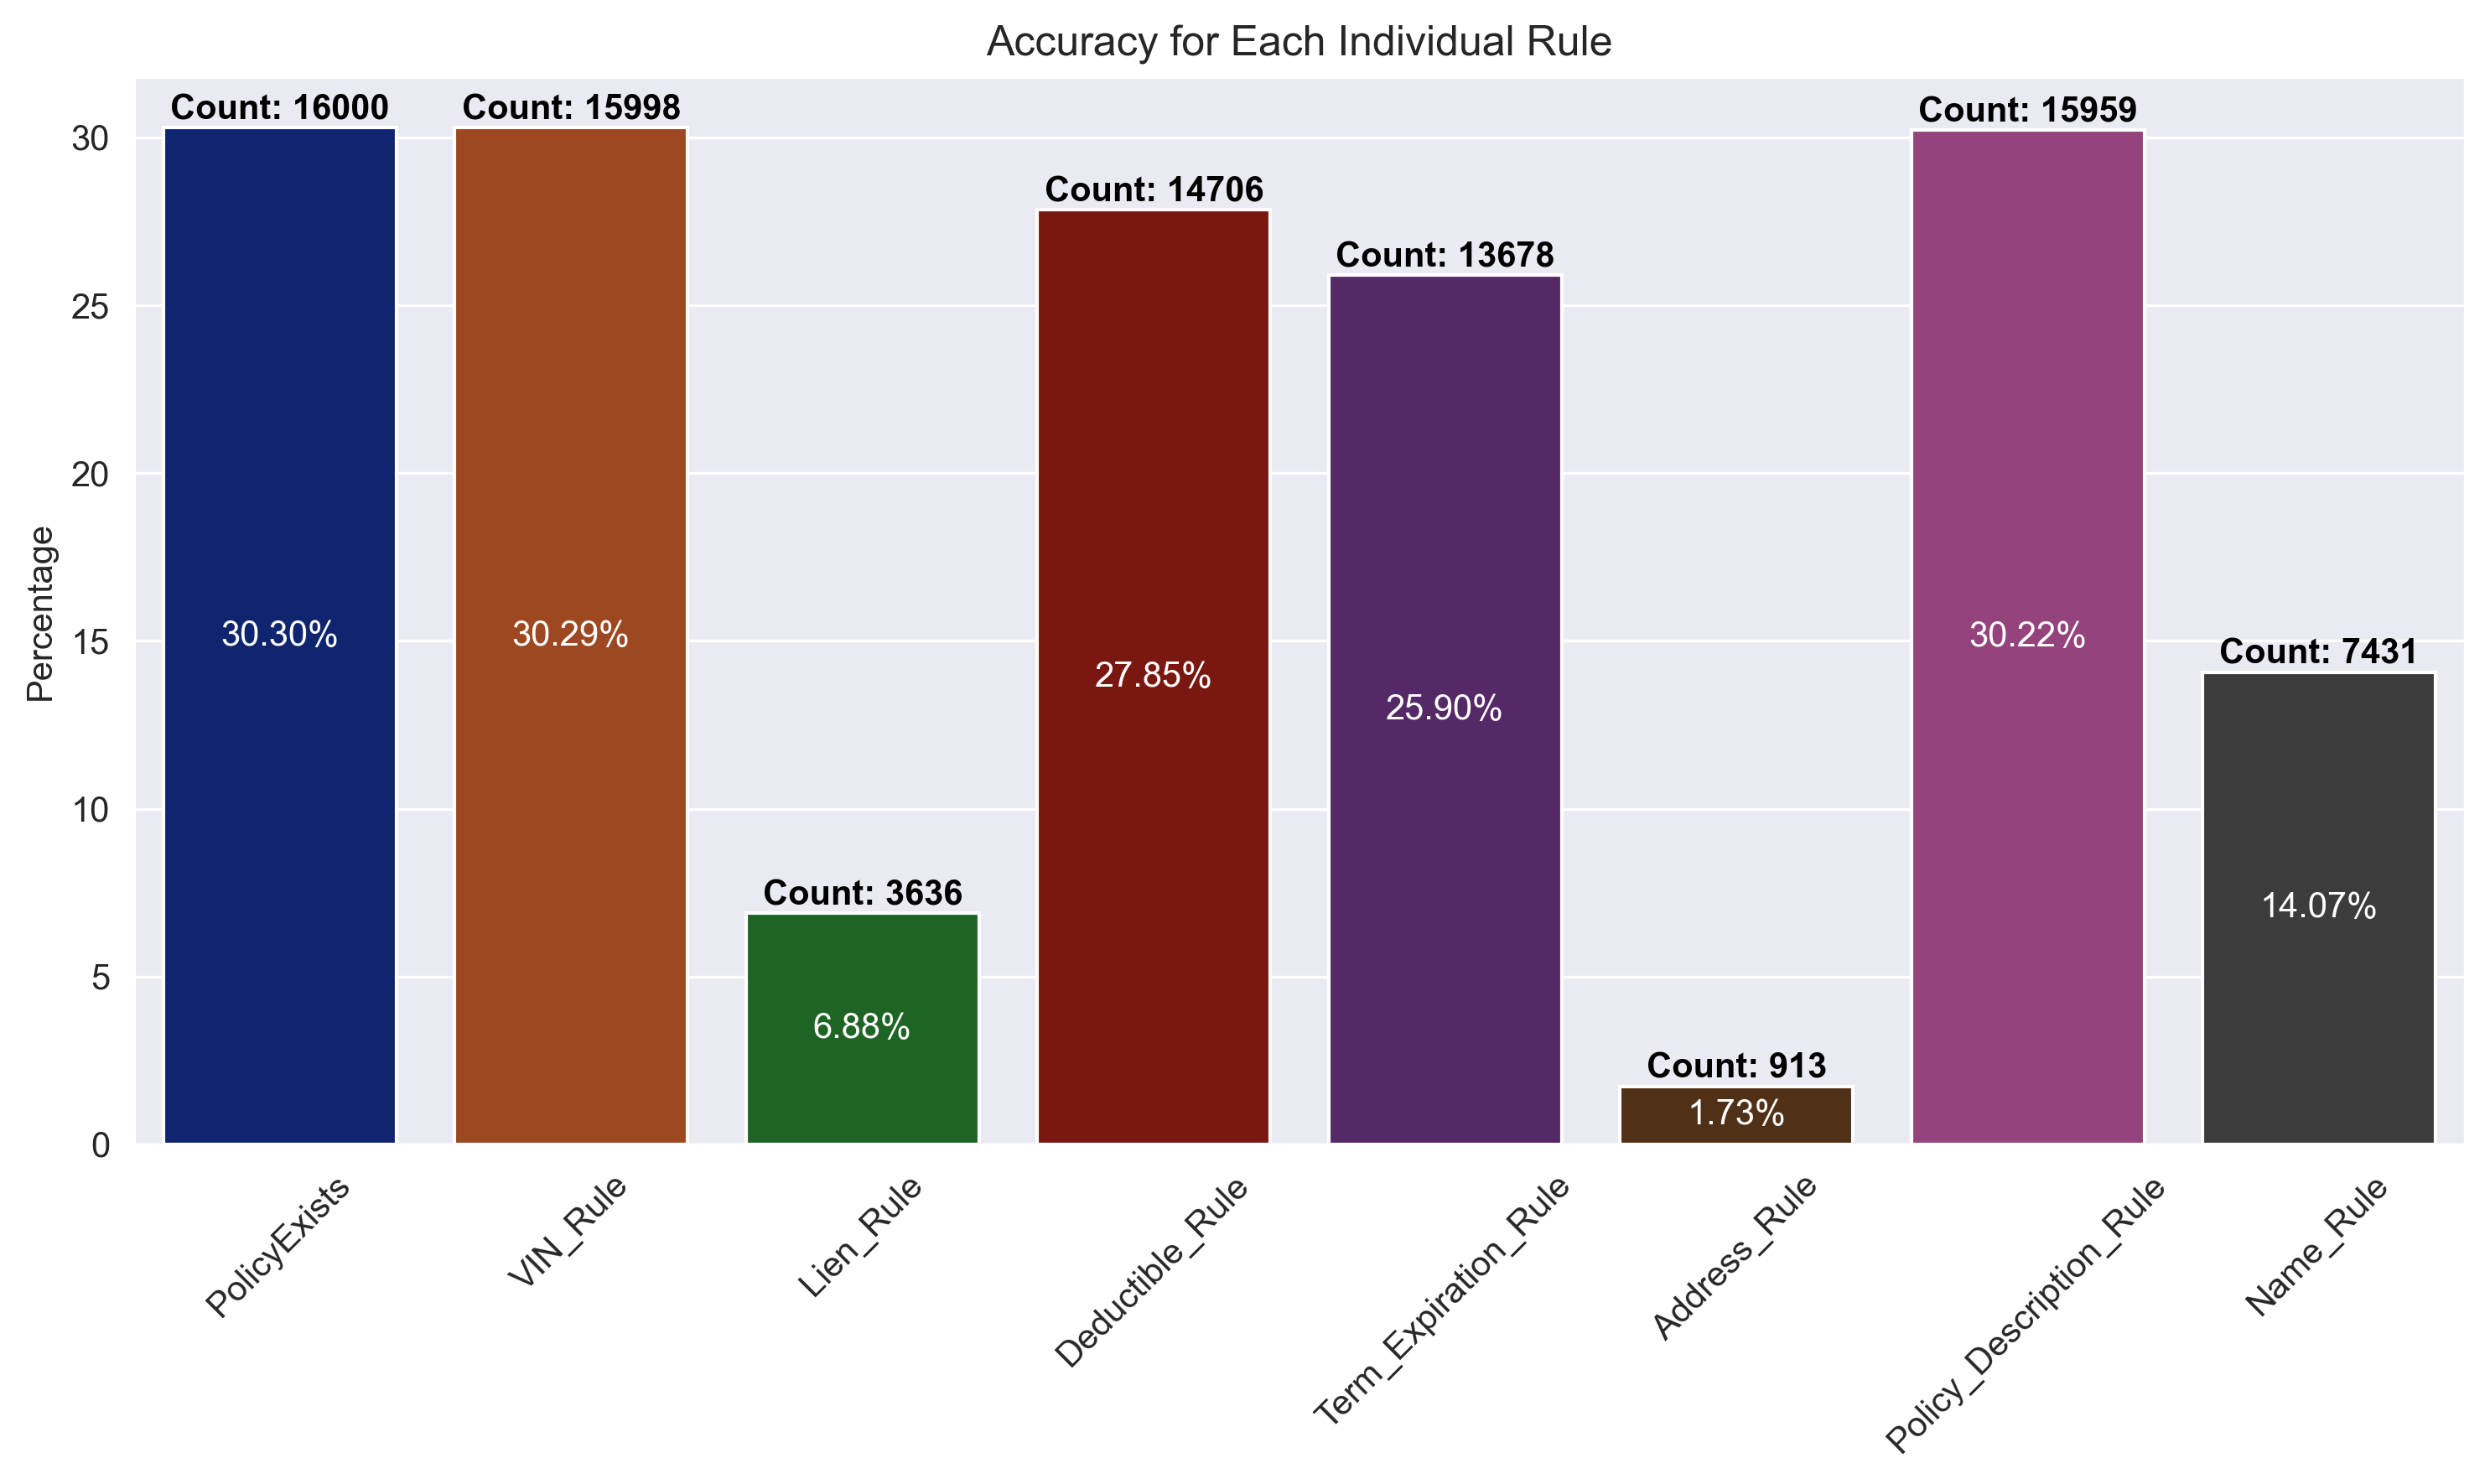

In [382]:
import pandas as pd
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt

df_input = pd.read_csv('../Result_70.tsv',sep='\t')
df_input = df_input.fillna('')

#parse the required information for the rules from xml

def parse_xml(xml_str):
    root = ET.fromstring(xml_str)
    policy_tag = root.find(".//Policies/Policy")
    policy_exists = policy_tag is not None and len(list(policy_tag)) > 0
    parsed_data = {
        "FullName": [],
        "VIN": [],
        "LienHolderName": [],
        "CollisionDeductibleAmount": [],
        "ComprehensiveDeductibleAmount": [],
        "RelationToPolicyHolderDescription": [],
        "TermExpirationDate": None,
        "TermEffectiveDate": None,
        "FinanceCompanyAddress": None
    }

    #name
    for subject in root.findall(".//Subjects/Subject"):
        given_name = subject.find('GivenName').text if subject.find('GivenName') is not None else ""
        middle_name = subject.find('MiddleName').text if subject.find('MiddleName') is not None else ""
        surname = subject.find('Surname').text if subject.find('Surname') is not None else ""
        full_name = " ".join(filter(None, [given_name, middle_name, surname]))
        parsed_data['FullName'].append(full_name)
        parsed_data["RelationToPolicyHolderDescription"].append(subject.findtext("RelationToPolicyHolder/Description"))

    #vin,deductibles
    for vehicle in root.findall(".//Vehicles/Vehicle"):
        parsed_data["VIN"].append(vehicle.findtext("VIN"))
        parsed_data["CollisionDeductibleAmount"].append(vehicle.findtext("CollisionDeductibleAmount"))
        parsed_data["ComprehensiveDeductibleAmount"].append(vehicle.findtext("ComprehensiveDeductibleAmount"))

    #lien,address
    for fin_info in root.findall(".//FinanceInformations/FinanceInformation"):
        parsed_data["LienHolderName"].append(fin_info.findtext("LienHolderName"))
        finance_address = fin_info.find("FinanceCompanyAddress")
        if finance_address is not None:
            address_parts = [
                finance_address.findtext('Street1'),
                finance_address.findtext('City'),
                finance_address.findtext('StateCode'),
                finance_address.findtext('Zip')
            ]
            address = ' '.join(filter(None, address_parts))
            parsed_data["FinanceCompanyAddress"] = address

    #terms
    parsed_data['TermEffectiveDate'] = root.findtext(".//PolicyInformation/TermEffectiveDate")
    parsed_data["TermExpirationDate"] = root.findtext(".//PolicyInformation/TermExpirationDate")

    return parsed_data, policy_exists


results = []

for idx, row in df_input.iterrows():
    xml_str = row["applicant_verisk"]
    id = row["AppId"]
    parsed_data, policy_exists = parse_xml(xml_str)
    parsed_data["id"] = id
    parsed_data["PolicyExists"] = policy_exists
    results.append(parsed_data)

#create df to add the results
df_output = pd.DataFrame(results)

#if there are two values for one id,put them in one row in format x, y

df_output["FullName"] = df_output["FullName"].apply(lambda x: ', '.join(filter(None, x)))
df_output["VIN"] = df_output["VIN"].apply(lambda x: ', '.join(filter(None, x)))
df_output["LienHolderName"] = df_output["LienHolderName"].apply(lambda x: ', '.join(filter(None, x)))
df_output["CollisionDeductibleAmount"] = df_output["CollisionDeductibleAmount"].apply(lambda x: ', '.join(filter(None, x)))
df_output["ComprehensiveDeductibleAmount"] = df_output["ComprehensiveDeductibleAmount"].apply(lambda x: ', '.join(filter(None, x)))
df_output["RelationToPolicyHolderDescription"] = df_output["RelationToPolicyHolderDescription"].apply(lambda x: ', '.join(filter(None, x)))


#drop druplicates

df_output.drop_duplicates(inplace=True)
#df_output



#read the whole sql data

df = df_input
#df = df.fillna('')

#function to combine strins so we can have applicant/co_appl name combined not separated by first/middle ..

def combine_strings(first,middle,last,suffix):
    if str(middle) != '':
        return str(first) + ' ' + str(middle) + ' ' + str(last)+ ' ' + str(suffix)
    else:
        return str(first) + ' ' + str(last)+ ' ' + str(suffix)
df['Applicant_Name'] = df[['applicant_firstnm','applicant_middlenm','applicant_lastnm','applicant_suffix']].apply(lambda df: combine_strings(df['applicant_firstnm'],df['applicant_middlenm'],df['applicant_lastnm'],df['applicant_suffix']),axis=1)
df['Co_Applicant_Name'] = df[['co_applicant_firstnm','co_applicant_middlenm','co_applicant_lastnm','co_applicant_suffix']].apply(lambda df: combine_strings(df['co_applicant_firstnm'],df['co_applicant_middlenm'],df['co_applicant_lastnm'],df['co_applicant_suffix']),axis=1)

#create df with the columns we need

columns_to_use = ['AppId','Applicant_Name','Co_Applicant_Name','VIN']
df_los = df[columns_to_use]
df_los['id'] = df_los['AppId']
df_los.drop('AppId',axis=1,inplace=True)
#drop duplicates if the only difference is the applicant report time
df_los_unique = df_los.drop_duplicates()
df_los_unique

#merge the two dataframes
df_combined = pd.merge(df_los_unique, df_output, on='id', how='inner')
df_combined = df_combined.drop_duplicates(subset=['id'], keep='first')

#vin rule
df_combined['VIN_x'] = df_combined['VIN_x'].str.strip().str.split(',').str[0]
df_combined['VIN_y'] = df_combined['VIN_y'].str.strip().str.split(',').str[0]
df_combined['VIN_Rule'] = df_combined['VIN_x'] == df_combined['VIN_y']
df_combined.rename({'VIN_x' : 'VIN_VERISK', 'VIN_y': 'VIN_LOS'},inplace=True,axis=1)

#lienholder rule

def check_substring(substr):
    if 'united auto credit' in str(substr.lower()):
        return True
    else:
        return False
#remove special characters
df_combined['LienHolderName'] = df_combined['LienHolderName'].str.replace(r'[^\w\s]', '', regex=True).astype(str)
df_combined['Lien_Rule'] = df_combined['LienHolderName'].apply(check_substring)

#deductible rule

df_combined['CollisionDeductibleAmount'] = df_combined['CollisionDeductibleAmount'].str.split(',').str[0]
df_combined['ComprehensiveDeductibleAmount'] = df_combined['ComprehensiveDeductibleAmount'].str.split(',').str[0]
df_combined['ComprehensiveDeductibleAmount'] = pd.to_numeric(df_combined['ComprehensiveDeductibleAmount'],errors='coerce')
df_combined['CollisionDeductibleAmount'] = pd.to_numeric(df_combined['ComprehensiveDeductibleAmount'],errors='coerce')
df_combined['ComprehensiveDeductibleAmount'] = df_combined['ComprehensiveDeductibleAmount'].astype('Int64')
df_combined['CollisionDeductibleAmount'] = df_combined['CollisionDeductibleAmount'].astype('Int64')
#neither can be over 1000
df_combined['Deductible_Rule'] =  (df_combined['CollisionDeductibleAmount'] <= 1000) & (df_combined['ComprehensiveDeductibleAmount'] <= 1000)

#time expired rule

df_combined['TermExpirationDate'] = pd.to_datetime(df_combined['TermExpirationDate'],format='%Y%m%d')
#df_combined['applicant_reportdt'] = pd.to_datetime(df_combined['applicant_reportdt'],errors='coerce').dt.normalize()
df_combined['TermEffectiveDate'] = pd.to_datetime(df_combined['TermEffectiveDate'],format='%Y%m%d')
df_combined['Term_Expiration_Rule'] = (df_combined['TermExpirationDate'] - df_combined['TermEffectiveDate']) >=pd.Timedelta('182 days')

#address rule

def check_address(address):
    if str(address) == 'PO BOX 164129 FT WORTH TX 76161' or str(address) == 'PO BOX 164129 FORT WORTH TX 76161' or str(address) == 'PO BOX 164129 FORTH WORTH TX 76161' or str(address) == 'P.O. BOX 164129 FORT WORTH TX 76161' or str(address) == 'P.O. BOX 164129 FORTH WORTH TX 76161' or str(address) == 'P.O. BOX 164129 FT WORTH TX 76161':
        return True
    else:
        return False
 
df_combined['Address_Rule'] = df_combined['FinanceCompanyAddress'].apply(check_address)

#policy description rule

#make function so we get the posiiton of excluded and put it in a list
#then use it to check corresponding name in fullname against los_name
def excluded_name_check(fullname, los_name, exclude_desc):
    exclusions = exclude_desc.split(', ')
    excluded_positions = []
    if exclude_desc == '':
        return False
    for i, exclusion in enumerate(exclusions):
        if 'Excluded' in exclusion:
            excluded_positions.append(i)
    if not excluded_positions:
        return True
    for position in excluded_positions:
        excluded_name = fullname.split(', ')[position]
        if excluded_name.strip() in los_name.strip():
            return False
    return True

#apply the function to the required columns
df_combined['Policy_Description_Rule'] = df_combined.apply(lambda row: excluded_name_check(row['FullName'], row['Applicant_Name'], row['RelationToPolicyHolderDescription']), axis=1)


#name rule

#two functions to compare names to applicant_name and co_applicant name (need to combine into one later)
def compare_names(names,los_name):
        for i in names.split(', '):
            if i !='' and i in los_name:
                return True
        else:
            return False
        
def compare_co_names(names,los_co_name):
    for i in names.split(', '):
        if i.strip() and i in los_co_name:
            return True
        elif not los_co_name.strip() and i.strip():
            return True
    else:
        return False
df_combined['name_comparison'] = df_combined[['FullName','Applicant_Name']].apply(lambda df_combined: compare_names(df_combined['FullName'],df_combined['Applicant_Name']),axis=1)
df_combined['coname_comparison'] = df_combined[['FullName','Co_Applicant_Name']].apply(lambda df_combined: compare_co_names(df_combined['FullName'],df_combined['Co_Applicant_Name']),axis=1)

#combine into one column and set to True only if both are True

df_combined['Name_Rule'] = (df_combined['name_comparison']) & (df_combined['coname_comparison'])

#drop the two unnecessary columns 
df_combined.drop(['name_comparison','coname_comparison'],axis=1,inplace=True)

df_combined['Deductible_Rule'] = df_combined['Deductible_Rule'].fillna(False)

df=pd.read_csv('konacno_konacno.tsv',sep='\t')
bool_columns = ['PolicyExists', 'VIN_Rule', 'Lien_Rule', 'Deductible_Rule', 
                'Term_Expiration_Rule', 'Address_Rule', 'Policy_Description_Rule','Name_Rule']

#number of rows where all columns are True
all_true_mask = df[bool_columns].all(axis=1)
all_true_count = all_true_mask.sum()

#numb rows where all columns are False
all_false_mask = ~df[bool_columns].any(axis=1)
all_false_count = all_false_mask.sum()

total_rows = len(df)

#any combination of True and False
mixed_count = total_rows - (all_true_count + all_false_count)


all_true_percentage = round((all_true_count / total_rows) * 100,2)
all_false_percentage = round((all_false_count / total_rows) * 100,2)
mixed_percentage = round((mixed_count / total_rows) * 100,2)

categories = ['Fully Verified','Partially Verified','None Verified']
counts = [all_true_count, mixed_count, all_false_count]
percentages = [all_true_percentage, mixed_percentage, all_false_percentage]


plt.figure(figsize=(10,6),dpi=300)
barplot = sns.barplot(x=categories,y=percentages,palette='inferno')
plt.title('Accuracy of Verisk Verification')
plt.ylabel('Percentage')
for i in range(len(categories)):
    barplot.text(i, percentages[i] / 2, f"{percentages[i]:.2f}%",color='white',ha='center',va='center',fontsize=10,weight='bold')
    barplot.text(i, percentages[i], f"Count: {counts[i]}", color='black', ha="center", va="bottom",weight='bold')
sns.set_style('darkgrid')
plt.tight_layout()
plt.savefig('konacno.png')


df=pd.read_csv('konacno_konacno.tsv',sep='\t')
bool_columns = ['PolicyExists', 'VIN_Rule', 'Lien_Rule', 'Deductible_Rule', 
                'Term_Expiration_Rule', 'Address_Rule', 'Policy_Description_Rule','Name_Rule']
#count and percentage of True values for each boolean column
counts = df[bool_columns].sum()
percentages = (counts / len(df)) * 100

plt.figure(figsize=(10, 6),dpi=300)
barplot = sns.barplot(x=bool_columns, y=percentages, palette='dark')
plt.title('Accuracy for Each Individual Rule')
plt.ylabel('Percentage')

for i, p in enumerate(barplot.patches):
    barplot.annotate(f'Count: {counts[i]}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points',weight='bold')
    barplot.annotate(f'{percentages[i]:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                     ha='center', va='center', fontsize=10, color='white')

plt.xticks(rotation=45) 
plt.tight_layout()
plt.savefig('konacno_all_cols.png')

In [380]:
df_combined['Deductible_Rule'] = df_combined['Deductible_Rule'].fillna(False)

In [2]:
import pandas as pd

In [353]:
df = pd.read_csv('../Result_70.tsv',sep='\t')

/var/folders/lh/x3hrpfns0kvft_vn9ntrvglm0000gn/T/ipykernel_11303/2471873367.py:1: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Result_70.tsv',sep='\t')


In [354]:
df = df[['AppId','applicant_reportdt']]

In [220]:
df = df[['AppId','CompanyNm']]

In [222]:
df.rename({'AppId':'id'},axis=1,inplace=True)

In [22]:
import xml.etree.ElementTree as ET
insurance_list = []
for i,row in df.iterrows():
    xml_str = row["applicant_verisk"]
    app_id = row['AppId']
    root = ET.fromstring(xml_str)
    for carrier in root.findall(".//Carrier"):
        carrier_name = carrier.find('Name').text
        insurance_list.append({'AppId' : app_id, 'Insurance_Company_Name' : carrier_name})
df_ins = pd.DataFrame(insurance_list)
df_ins

,AppId,Insurance_Company_Name
0,10231143,COAST NATIONAL INSUR
1,10248299,GOVERNMENT EMP INSCO
2,10229075,PROGRESSIVE GROUPS
3,10243152,ROOT INSURANCE COMPA
4,10242799,PROGRESSIVE GROUPS
...,...,...
16297,8205068,CSAA F&C IC
16298,8208932,INFINITY AUTO INSURA
16299,8208734,ESURANCE PROP CAS
16300,8201308,PROGRESSIVE GROUPS


In [356]:
df.rename({'AppId':'id'},axis=1,inplace=True)

In [189]:
df_complete = pd.read_csv('Complete Verisk Verification - Sheet1 (1).tsv',sep = '\t')
df_complete

,Applicant_Name,Co_Applicant_Name,VIN_VERISK,id,FullName,VIN_LOS,LienHolderName,CollisionDeductibleAmount,ComprehensiveDeductibleAmount,RelationToPolicyHolderDescription,...,TermEffectiveDate,FinanceCompanyAddress,PolicyExists,VIN_Rule,Lien_Rule,Deductible_Rule,Term_Expiration_Rule,Address_Rule,Policy_Description_Rule,Name_Rule
0,EDWIN J CLEMENTE FIGUEROA,NaN,19XFB2F99DE072365,10243637,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,False,False,False,False,False,False
1,STEFAN COLLINS,NaN,3N1AB7AP8HY338351,10252328,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,False,False,False,False,False,False
2,TYLER PORFIRIO,JANICE L PORFIRIO,5UXWX7C56DL979743,10247322,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,False,False,False,False,False,False
3,ELISSANDRA PEREZ MACHADO,NaN,1GCRCREH9GZ231504,10255755,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,False,False,False,False,False,False
4,JEICY SANCHEZ,NaN,2GNAXJEV3J6283648,10252967,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52808,JORDAN REYNOLDS,NaN,1C6RD7FT6CS271828,8202083,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,False,False,False,False,False,False
52809,PEDRO DIAZ,NaN,JN1AZ36A24M253673,8224360,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,False,False,False,False,False,False
52810,GONZALO A GUZMAN GONZALEZ,NaN,1FM5K8D82FGA91346,8205683,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,False,False,False,False,False,False
52811,DAMIAN RADMANOVICH,NaN,1C4BJWDG8CL187555,8223606,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,False,False,False,False,False,False


In [223]:
df_dodato_ins_name = pd.merge(df_complete,df,on='id',how='left')
df_dodato_ins_name

,Applicant_Name,Co_Applicant_Name,VIN_VERISK,id,FullName,VIN_LOS,LienHolderName,CollisionDeductibleAmount,ComprehensiveDeductibleAmount,RelationToPolicyHolderDescription,...,FinanceCompanyAddress,PolicyExists,VIN_Rule,Lien_Rule,Deductible_Rule,Term_Expiration_Rule,Address_Rule,Policy_Description_Rule,Name_Rule,CompanyNm
0,EDWIN J CLEMENTE FIGUEROA,NaN,19XFB2F99DE072365,10243637,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,PROGRESSIVE
1,STEFAN COLLINS,NaN,3N1AB7AP8HY338351,10252328,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,Dairyland
2,TYLER PORFIRIO,JANICE L PORFIRIO,5UXWX7C56DL979743,10247322,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,STATE FARM
3,ELISSANDRA PEREZ MACHADO,NaN,1GCRCREH9GZ231504,10255755,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,national general
4,JEICY SANCHEZ,NaN,2GNAXJEV3J6283648,10252967,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,geico insurance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52808,JORDAN REYNOLDS,NaN,1C6RD7FT6CS271828,8202083,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,DIRECT
52809,PEDRO DIAZ,NaN,JN1AZ36A24M253673,8224360,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,national general
52810,GONZALO A GUZMAN GONZALEZ,NaN,1FM5K8D82FGA91346,8205683,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,Gainsco
52811,DAMIAN RADMANOVICH,NaN,1C4BJWDG8CL187555,8223606,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,GEICO IDEMNITY


In [357]:
df_time = pd.merge(df_complete,df,on='id',how='left')

In [77]:
bool_columns = ['PolicyExists', 'VIN_Rule', 'Lien_Rule', 'Deductible_Rule', 
                'Term_Expiration_Rule', 'Address_Rule', 'Policy_Description_Rule','Name_Rule']

In [224]:
df = df_dodato_ins_name[['PolicyExists', 'VIN_Rule', 'Lien_Rule', 'Deductible_Rule', 
                'Term_Expiration_Rule', 'Address_Rule', 'Policy_Description_Rule','Name_Rule','CompanyNm']]

In [226]:
df['CompanyNm'] = df['CompanyNm'].str.strip().str.lower()
boolean_columns = [
    'PolicyExists', 'VIN_Rule', 'Lien_Rule', 'Deductible_Rule',
    'Term_Expiration_Rule', 'Address_Rule', 'Policy_Description_Rule', 'Name_Rule'
]

#all boolean columns are True
all_true_df = df[df[boolean_columns].all(axis=1)]

#at least one boolean column is True
at_least_one_true_df = df[(df[boolean_columns].any(axis=1)) & (~df[boolean_columns].all(axis=1))]

all_false_df = df[~df[boolean_columns].any(axis=1)]

#count of each Insurance_Company_Name in both filtered DataFrames
all_true_counts = all_true_df['CompanyNm'].value_counts()
all_false_counts = all_false_df['CompanyNm'].value_counts()
at_least_one_true_counts = at_least_one_true_df['CompanyNm'].value_counts()


print("Counts where all boolean columns are True:")
print(all_true_counts.head(10))

print("\nCounts where all boolean columns are False:")
print(all_false_counts.head(10))

print("\nCounts where at least one boolean column is True:")
print(at_least_one_true_counts.head(10))

Counts where all boolean columns are True:
ocean harbor cas        129
root insurance compa     57
mga insurance compan     45
ocean harbor             40
equity ins. co.          25
integon general insu     18
direct general insur     18
infinity insurance c     18
lib mutual personal      15
national general         14
Name: CompanyNm, dtype: int64

Counts where all boolean columns are False:
progressive         4946
geico               3568
state farm          2940
national general    1014
usaa                 824
allstate             737
uaic                 621
bristol west         456
kemper               378
dairyland            371
Name: CompanyNm, dtype: int64

Counts where at least one boolean column is True:
progressive groups      3528
geico                   1580
progressive              763
state farm insurance     355
direct general insur     318
root insurance compa     306
integon indemnity co     275
geico indemnity comp     264
ocean harbor cas         242
peak prope

/var/folders/lh/x3hrpfns0kvft_vn9ntrvglm0000gn/T/ipykernel_11303/1885796046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CompanyNm'] = df['CompanyNm'].str.strip().str.lower()


In [271]:
only_in_all_false = set(all_false_counts.index) - set(at_least_one_true_counts.index)

In [228]:
only_in_all_false_counts = all_false_counts[all_false_counts.index.isin(only_in_all_false)]


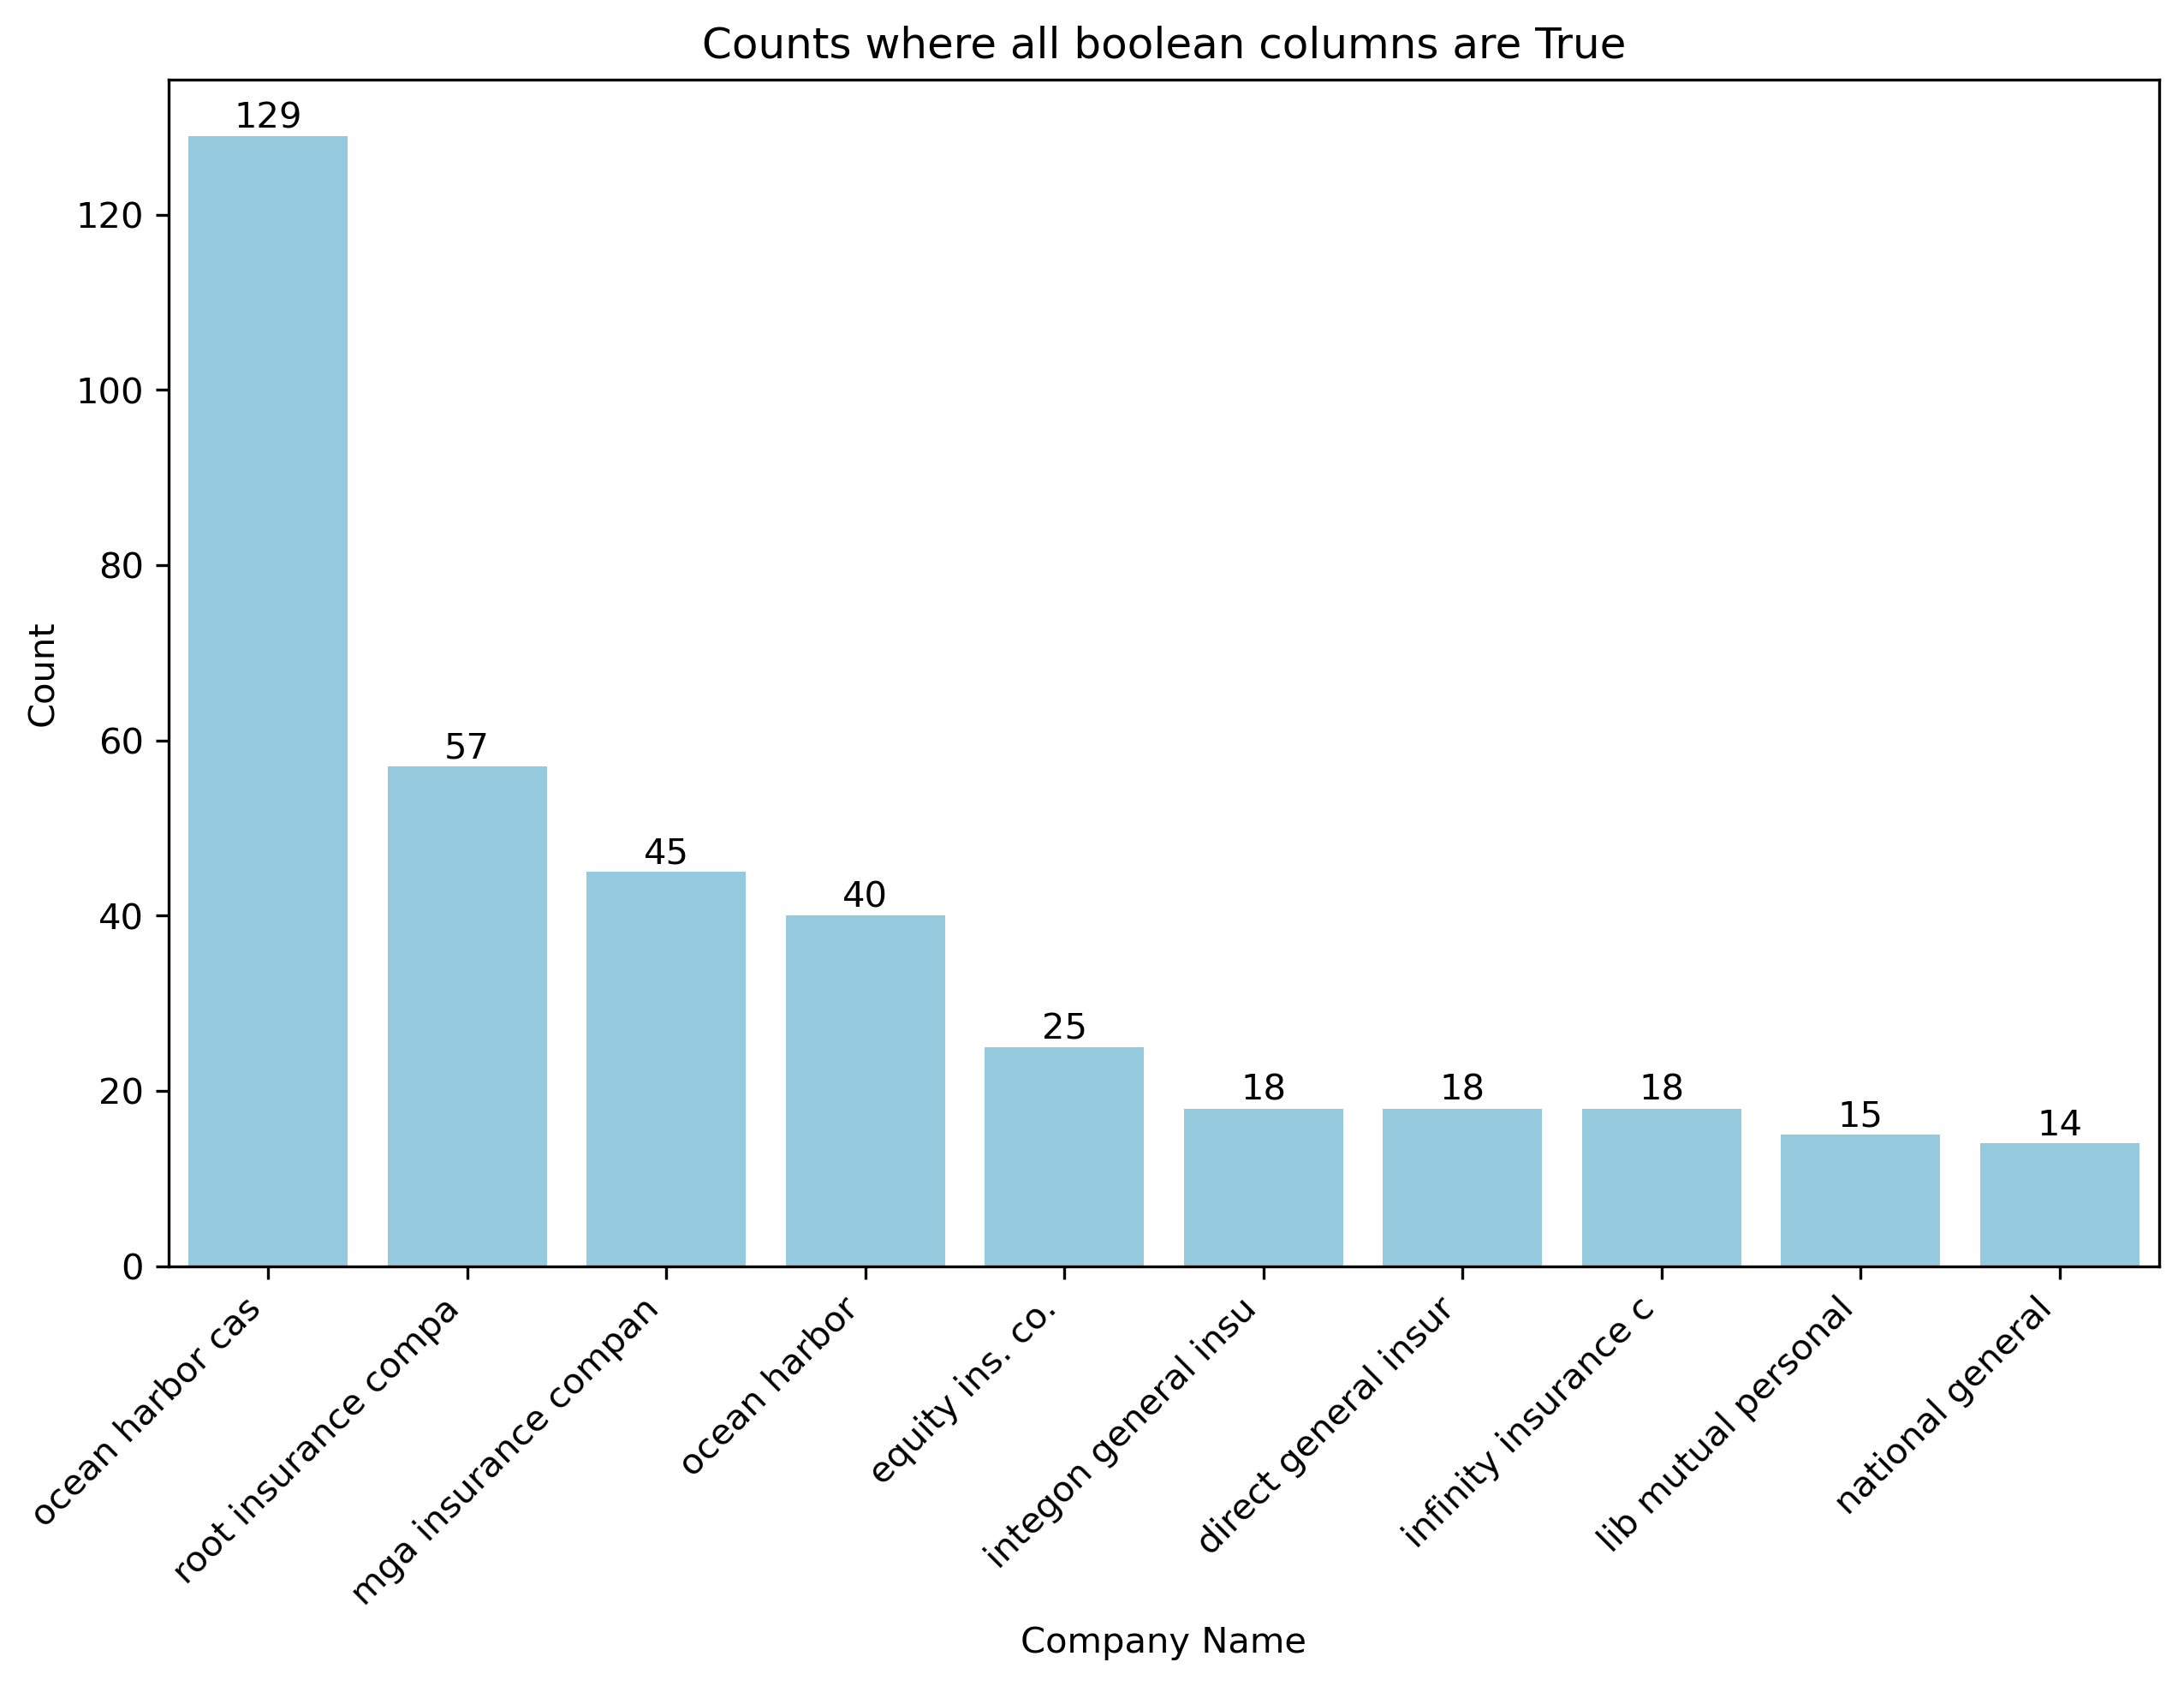

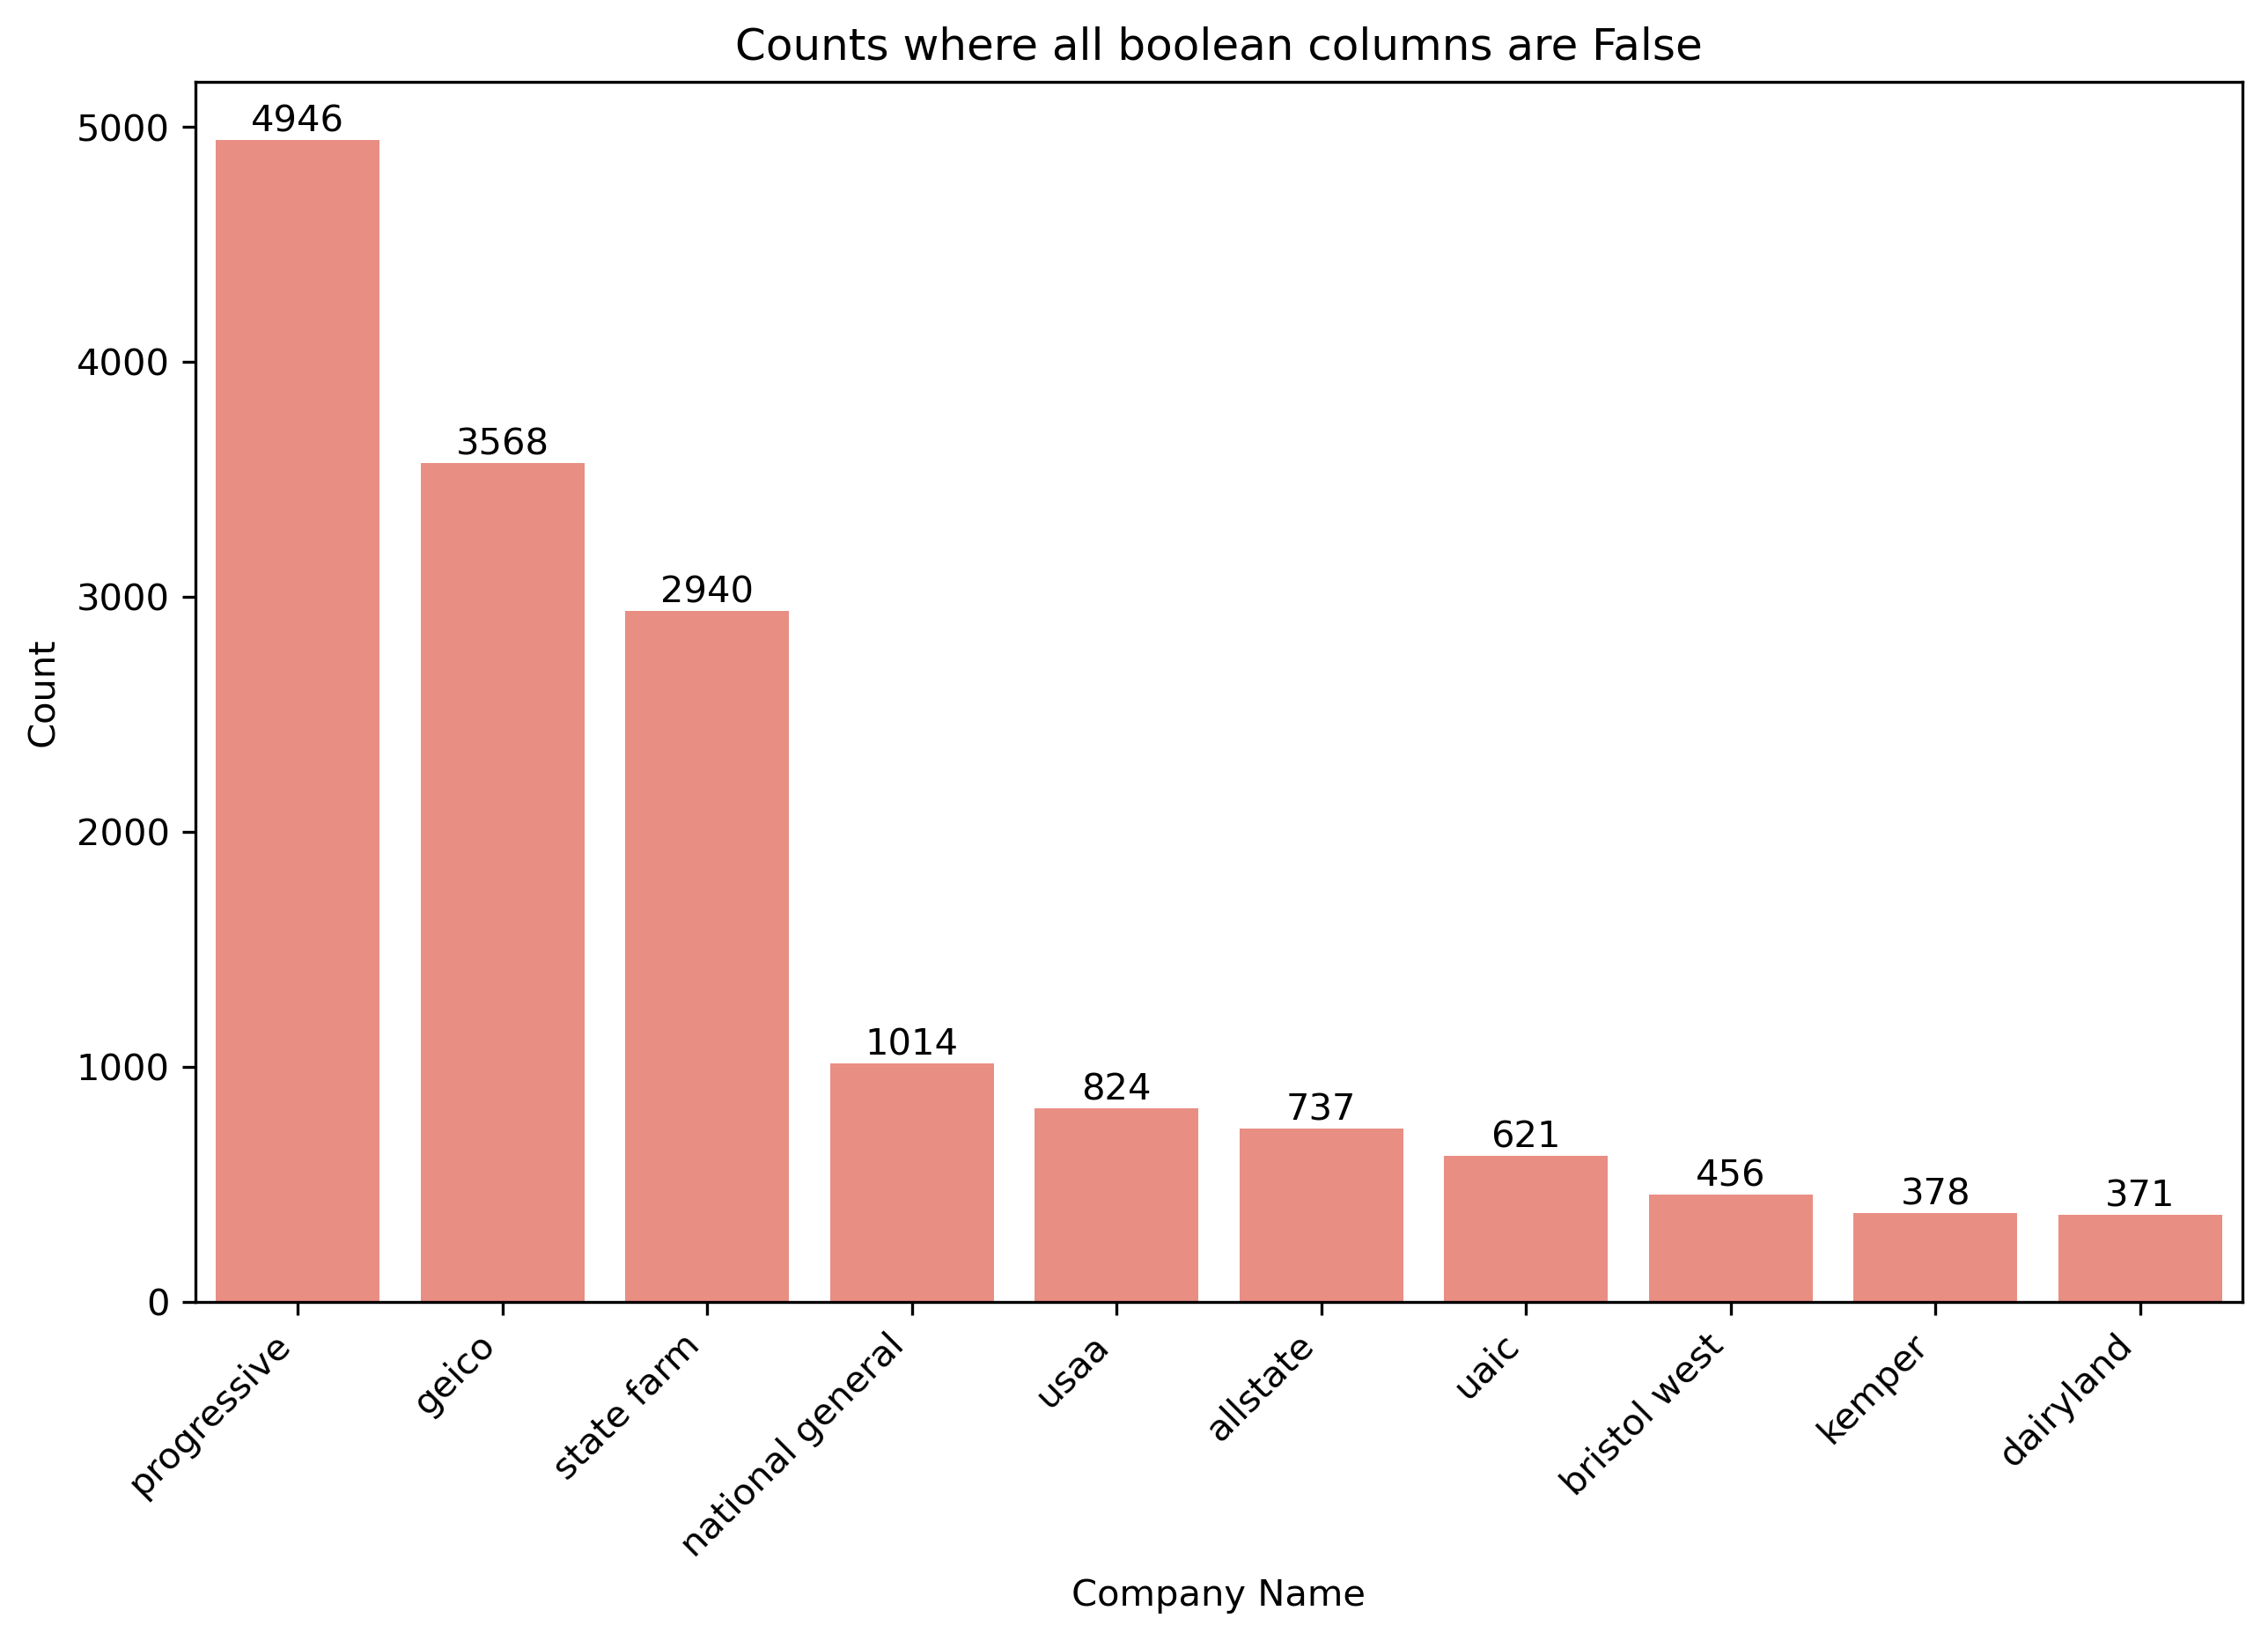

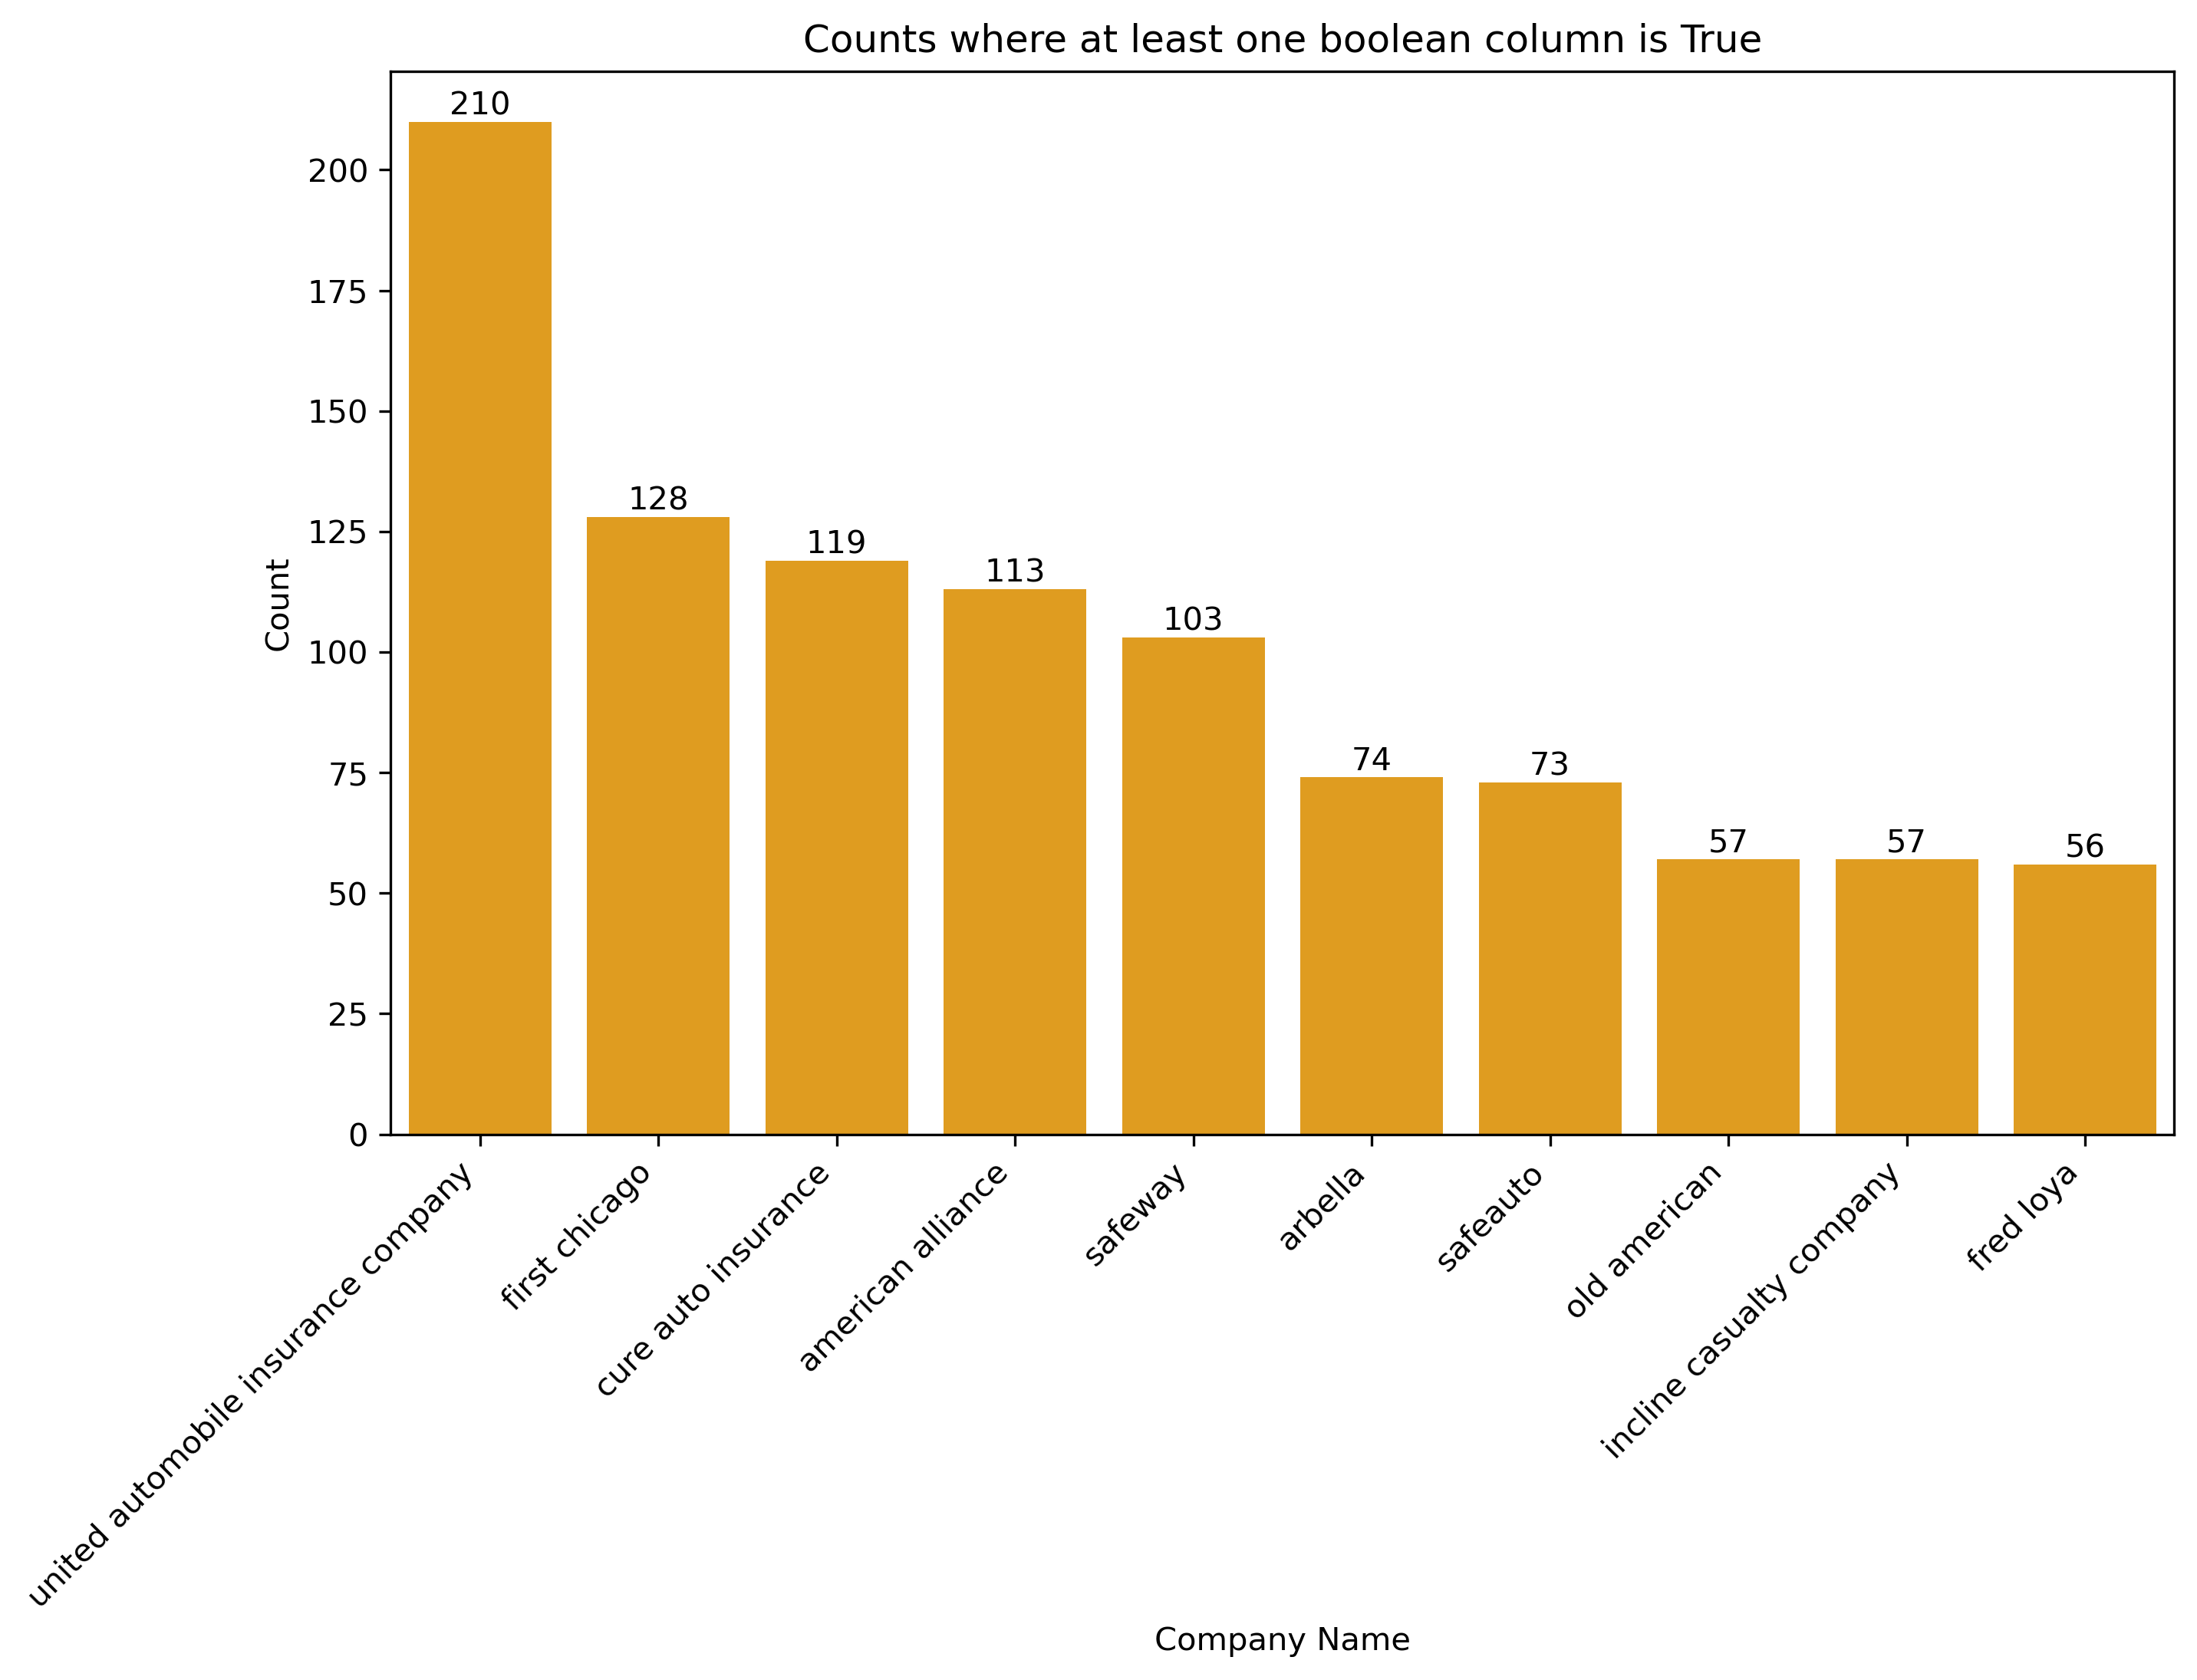

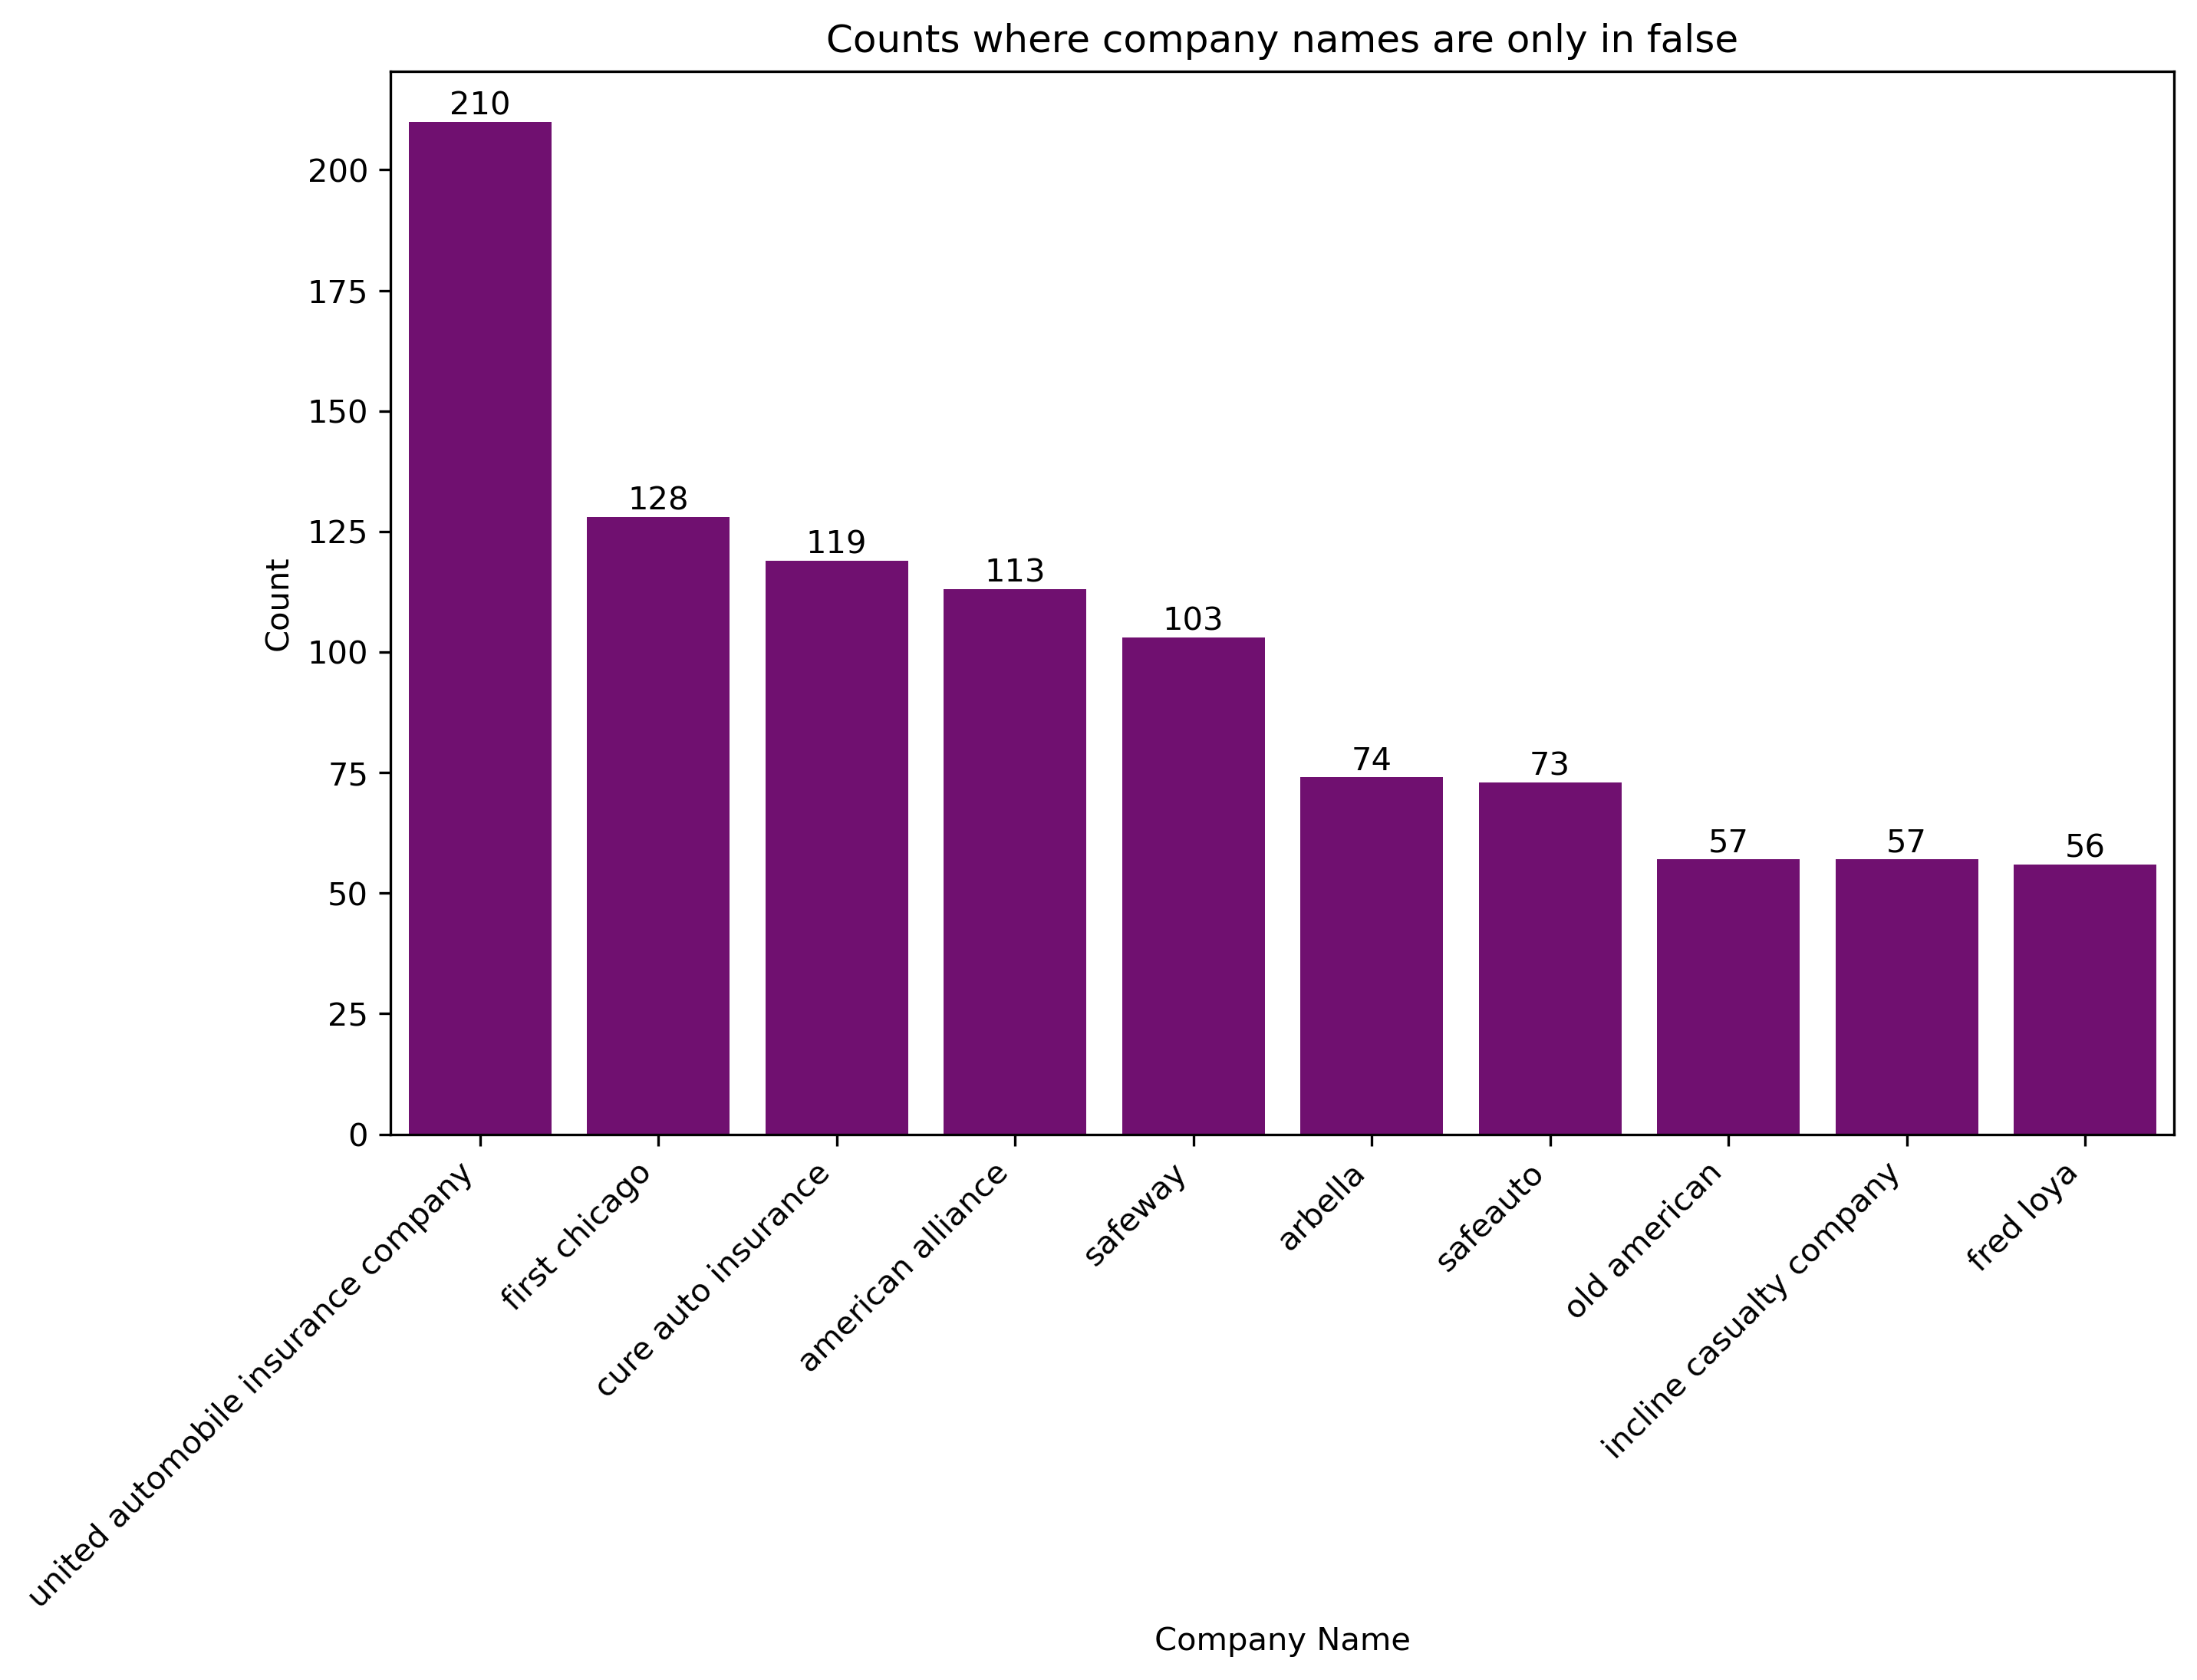

In [282]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

#plotting the counts where all boolean columns are True
sns.barplot(x=all_true_counts.head(10).index, y=all_true_counts.head(10).values, color='skyblue')
ax.set_title('Counts where all boolean columns are True')
ax.set_xlabel('Company Name')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
annotate_bars(ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

#plotting the counts where all boolean columns are False
sns.barplot(x=all_false_counts.head(10).index, y=all_false_counts.head(10).values, color='salmon')
ax.set_title('Counts where all boolean columns are False')
ax.set_xlabel('Company Name')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
annotate_bars(ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

#plotting the counts where at least one boolean column is True
sns.barplot(data=df_z.head(10), y='Count', x='CompanyNm', ax=ax, color='orange')
ax.set_title('Counts where at least one boolean column is True')
ax.set_xlabel('Company Name')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
annotate_bars(ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

#plotting the counts where company names are only in false counts
sns.barplot(data=df_z.head(10), y='Count', x='CompanyNm', ax=ax, color='purple')
ax.set_title('Counts where company names are only in false')
ax.set_xlabel('Company Name')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
annotate_bars(ax)
plt.show()


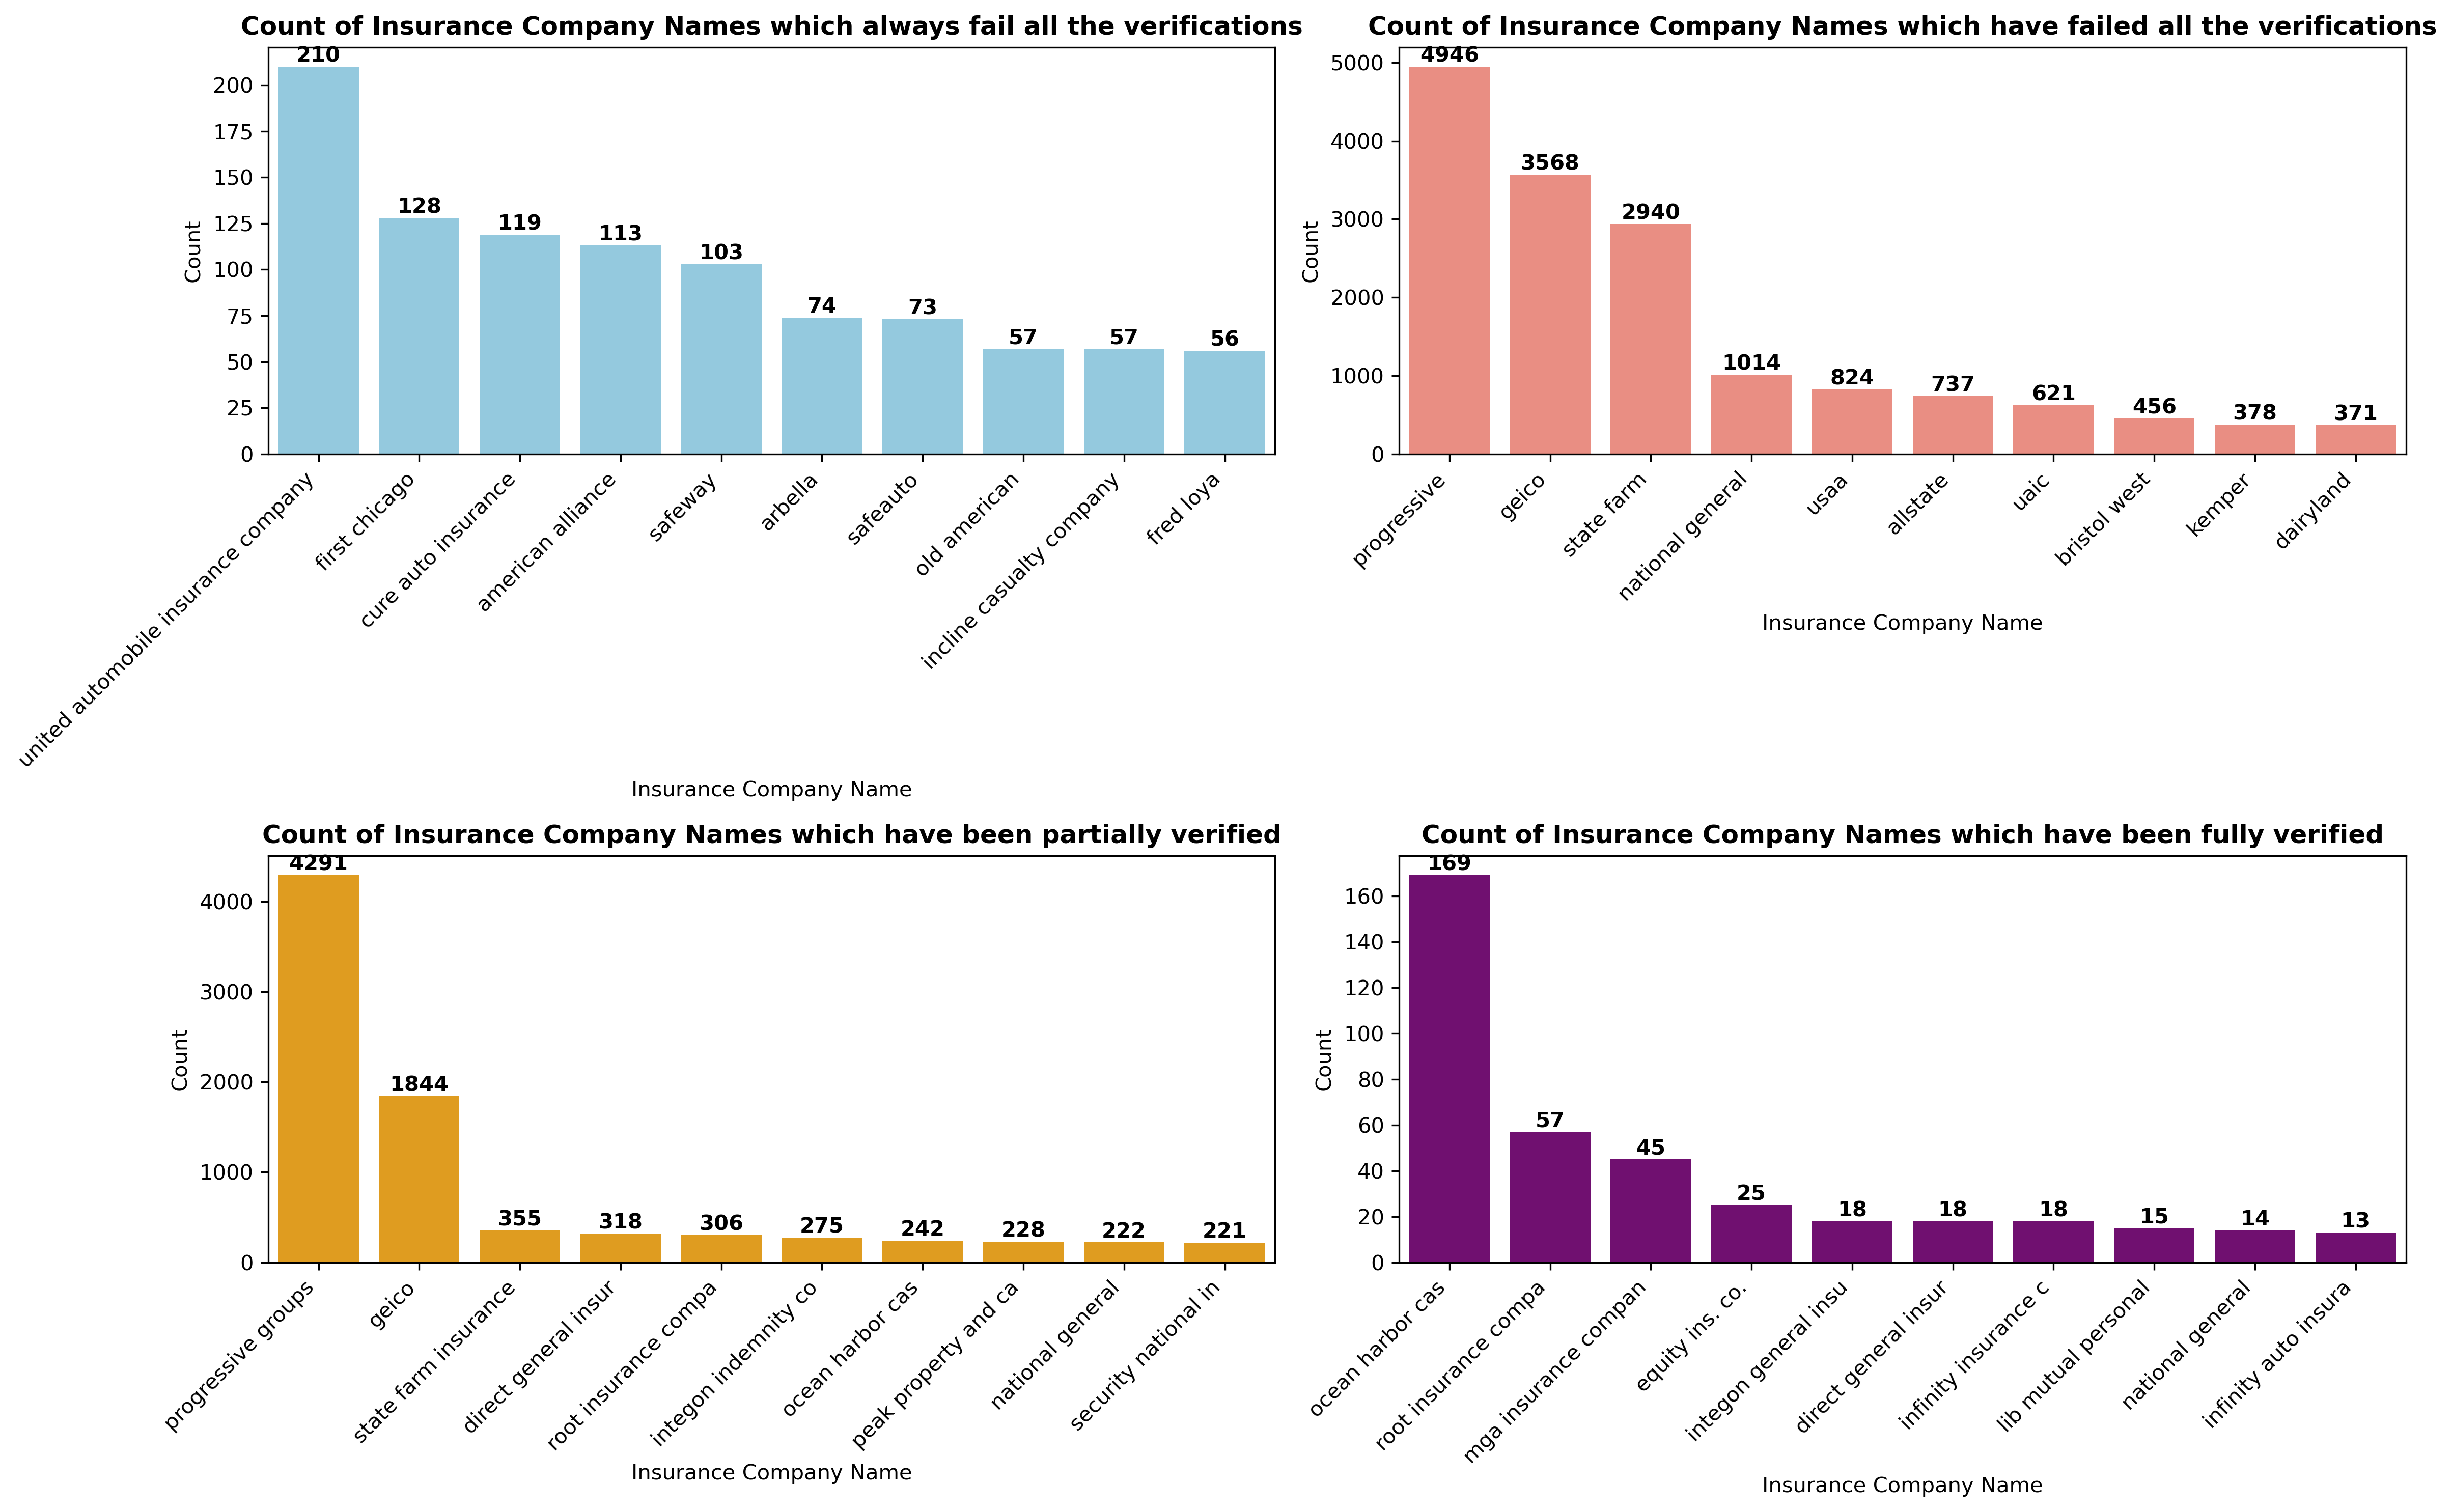

In [348]:
import seaborn as sns
import matplotlib.pyplot as plt

def annotate_bars(ax):
    ymax = ax.get_ylim()[1]
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(format(height, '.0f'), 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', 
                    xytext=(0, min(0.1, 0.05 * ymax)),  
                    textcoords='offset points',fontweight='bold',color='black')

fig, axs = plt.subplots(2, 2, figsize=(16, 10), dpi=300)

#company names that have never passed any of the verification in any instance
sns.barplot(data=df_z.head(10), y='Count', x='CompanyNm', ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('Count of Insurance Company Names which always fail all the verifications',fontweight='bold')
axs[0, 0].set_xlabel('Insurance Company Name')
axs[0, 0].set_ylabel('Count')
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=45, ha='right')
annotate_bars(axs[0, 0])

#count of company names which failed all the verifications
sns.barplot(x=all_false_counts.head(10).index, y=all_false_counts.head(10).values, color='salmon', ax=axs[0, 1])
axs[0, 1].set_title('Count of Insurance Company Names which have failed all the verifications',fontweight='bold')
axs[0, 1].set_xlabel('Insurance Company Name')
axs[0, 1].set_ylabel('Count')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45, ha='right')
annotate_bars(axs[0, 1])

#partially verified count
sns.barplot(data=df_1.head(10), y='Count', x='CompanyNm', ax=axs[1, 0], color='orange')
axs[1, 0].set_title('Count of Insurance Company Names which have been partially verified',fontweight='bold')
axs[1, 0].set_xlabel('Insurance Company Name')
axs[1, 0].set_ylabel('Count')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=45, ha='right')
annotate_bars(axs[1, 0])

#fully verified
sns.barplot(data=df_1.head(10), y='Count', x='CompanyNm', ax=axs[1, 1], color='purple')
axs[1, 1].set_title('Count of Insurance Company Names which have been fully verified',fontweight='bold')
axs[1, 1].set_xlabel('Insurance Company Name')
axs[1, 1].set_ylabel('Count')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha='right')
annotate_bars(axs[1, 1])


plt.tight_layout() 
plt.savefig('aj_probaj.png')

In [323]:
def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    xytext=(0, 0.2), 
                    textcoords='offset points')

In [294]:
all_true_counts.head(11)

ocean harbor cas        129
root insurance compa     57
mga insurance compan     45
ocean harbor             40
equity ins. co.          25
integon general insu     18
direct general insur     18
infinity insurance c     18
lib mutual personal      15
national general         14
infinity auto insura     13
Name: CompanyNm, dtype: int64

In [297]:
df_1 = pd.read_csv('Verisk verification - Sheet10 (3).tsv',sep='\t')
df_1

,CompanyNm,Count
0,ocean harbor cas,169
1,root insurance compa,57
2,mga insurance compan,45
3,equity ins. co.,25
4,integon general insu,18
5,direct general insur,18
6,infinity insurance c,18
7,lib mutual personal,15
8,national general,14
9,infinity auto insura,13


In [121]:
df.rename({'AppId':'id'},axis=1,inplace=True)
df_time = df[['id','applicant_reportdt']]
df_time

,id,applicant_reportdt
0,10243637,2024-06-04 14:22:08.670
1,10252328,2024-06-04 13:40:03.917
2,10247322,2024-06-04 11:46:40.857
3,10255755,2024-06-04 11:41:59.810
4,10252967,2024-06-04 11:12:27.867
...,...,...
52808,8202083,2023-01-01 10:00:50.757
52809,8224360,2023-01-01 10:00:39.883
52810,8205683,2023-01-01 10:00:32.287
52811,8223606,2023-01-01 10:00:31.593


In [122]:
df_combined = pd.merge(df_complete,df_time,on='id',how='left')
df_combined

,Applicant_Name,Co_Applicant_Name,VIN_VERISK,id,FullName,VIN_LOS,LienHolderName,CollisionDeductibleAmount,ComprehensiveDeductibleAmount,RelationToPolicyHolderDescription,...,FinanceCompanyAddress,PolicyExists,VIN_Rule,Lien_Rule,Deductible_Rule,Term_Expiration_Rule,Address_Rule,Policy_Description_Rule,Name_Rule,applicant_reportdt
0,EDWIN J CLEMENTE FIGUEROA,NaN,19XFB2F99DE072365,10243637,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,2024-06-04 14:22:08.670
1,STEFAN COLLINS,NaN,3N1AB7AP8HY338351,10252328,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,2024-06-04 13:40:03.917
2,TYLER PORFIRIO,JANICE L PORFIRIO,5UXWX7C56DL979743,10247322,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,2024-06-04 11:46:40.857
3,ELISSANDRA PEREZ MACHADO,NaN,1GCRCREH9GZ231504,10255755,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,2024-06-04 11:41:59.810
4,JEICY SANCHEZ,NaN,2GNAXJEV3J6283648,10252967,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,2024-06-04 11:12:27.867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52808,JORDAN REYNOLDS,NaN,1C6RD7FT6CS271828,8202083,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,2023-01-01 10:00:50.757
52809,PEDRO DIAZ,NaN,JN1AZ36A24M253673,8224360,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,2023-01-01 10:00:39.883
52810,GONZALO A GUZMAN GONZALEZ,NaN,1FM5K8D82FGA91346,8205683,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,2023-01-01 10:00:32.287
52811,DAMIAN RADMANOVICH,NaN,1C4BJWDG8CL187555,8223606,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,False,False,2023-01-01 10:00:31.593


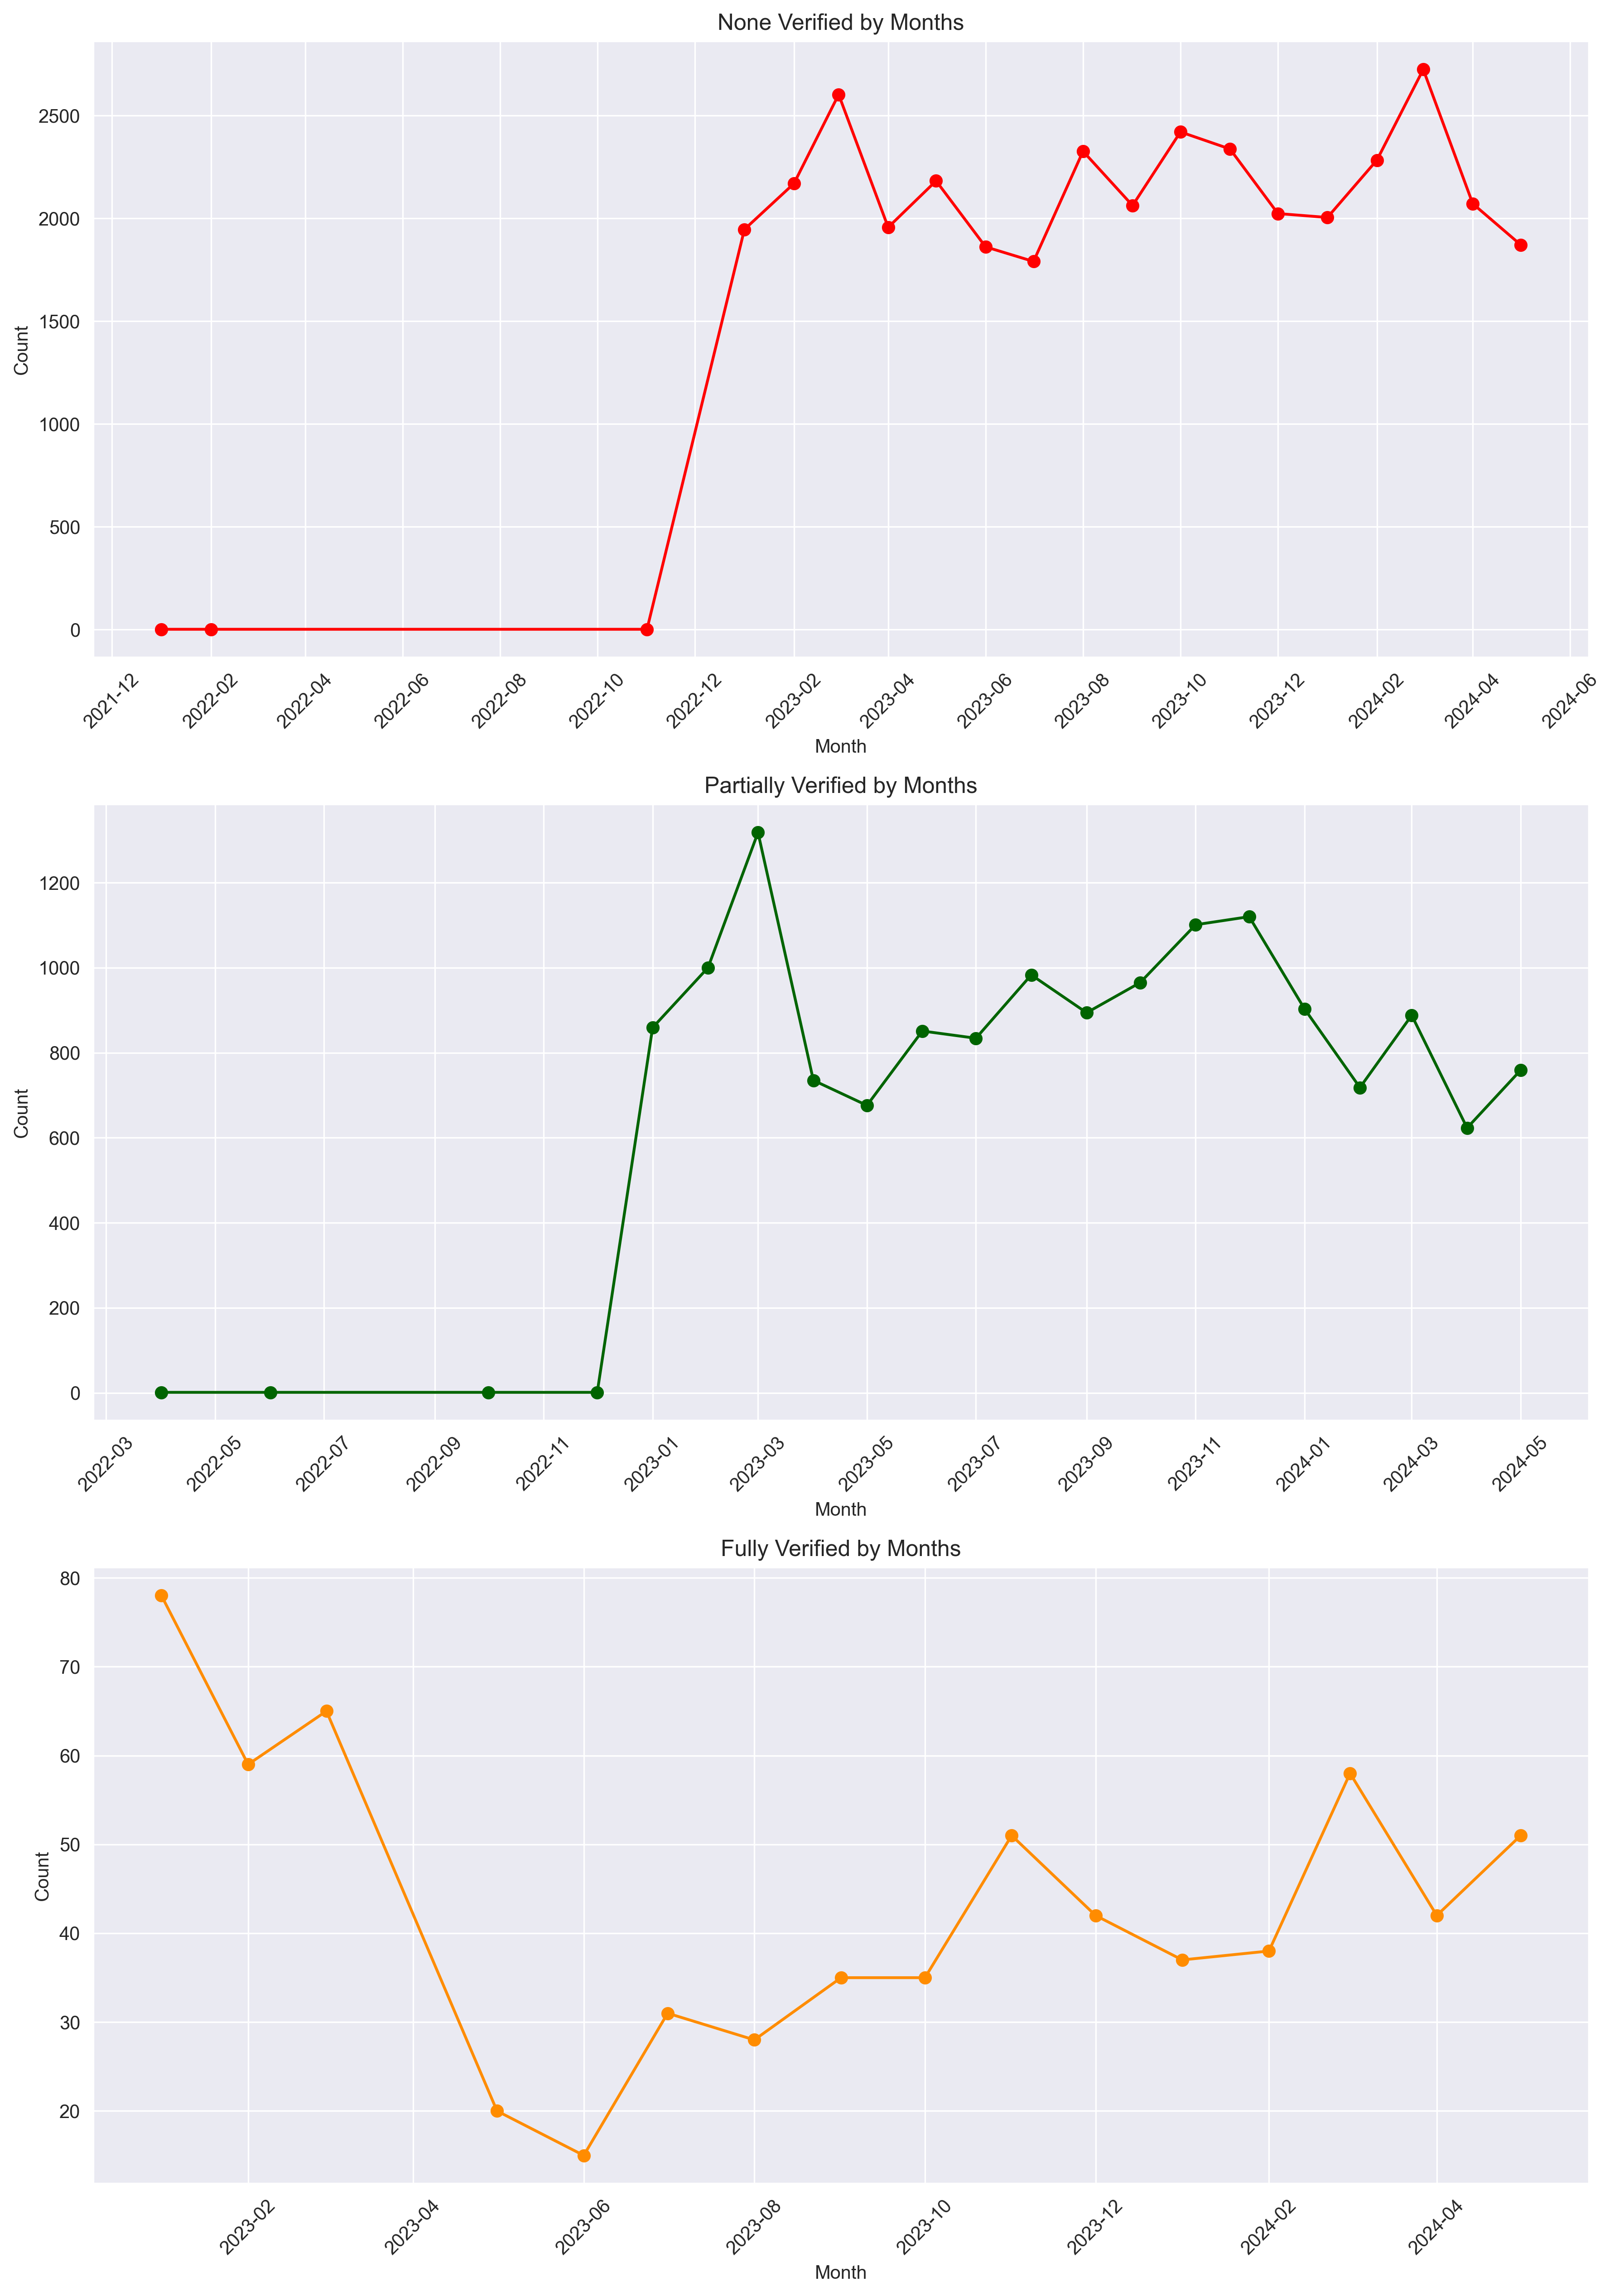

In [385]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

data1 = {
    'Month': [
        '2022-01', '2022-02', '2022-11', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', 
        '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', 
        '2024-02', '2024-03', '2024-04', '2024-05'
    ],
    'Count': [
        1, 1, 1, 1946, 2169, 2602, 1956, 2182, 1861, 1790, 2326, 2062, 2420, 2337, 2023, 2004, 
        2283, 2724, 2071, 1871
    ]
}

data2 = {
    'Month': [
        '2022-04', '2022-06', '2022-10', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', 
        '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', 
        '2024-01', '2024-02', '2024-03', '2024-04', '2024-05'
    ],
    'Count': [
        1, 1, 1, 1, 859, 1000, 1318, 735, 676, 851, 834, 983, 894, 965, 1101, 1120, 903, 718, 
        888, 623, 759
    ]
}

data3 = {
    'Month': [
        '2023-01', '2023-02', '2023-03', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', 
        '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05'
    ],
    'Count': [
        78, 59, 65, 20, 15, 31, 28, 35, 35, 51, 42, 37, 38, 58, 42, 51
    ]
}


df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)

#convert 'Month' to datetime for proper plotting
df1['Month'] = pd.to_datetime(df1['Month'])
df2['Month'] = pd.to_datetime(df2['Month'])
df3['Month'] = pd.to_datetime(df3['Month'])


fig, axs = plt.subplots(3, 1, figsize=(12, 17), dpi=300)

#plot for the first dataset
axs[0].plot(df1['Month'], df1['Count'], marker='o', color='red')
axs[0].set_title('None Verified by Months')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Count')
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

#plot for the second dataset
axs[1].plot(df2['Month'], df2['Count'], marker='o', color='darkgreen')
axs[1].set_title('Partially Verified by Months')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Count')
axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)

#plot for the third dataset
axs[2].plot(df3['Month'], df3['Count'], marker='o', color='darkorange')
axs[2].set_title('Fully Verified by Months')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Count')
axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(True)

plt.tight_layout()
plt.savefig('over_time_verisk.png')
